# Graph for time series 

GTS ("graph for time series") introduced by <span style="font-variant:small-caps;">Shang et al. (2021)</span> is an advanced GNN that allows to forecast multiple interrelated time series simultaneously, learning a graph between the different time series along the way and using a pre-existing graph to make sure the learned graph is still somewhat similar to the pre-existing graph. All in all, more accurate forecasts are the goal of GTS. 

Three baselines have been fit in advance to later compare the performance of GTS to: static forecasting, historical average forecasting and vector autoregression. We compare the performance of the four models with regard to three metrics: mean absolute error (MAE), mean absolute percentage error (MAPE) and root mean square error (RMSE).

For our 57 time series with 24 observations each, we choose the train-validation-test split such that we have the first 15 observations, i.e., the ones from 09-2019 to 11-2020, in the training set, the following 3 observations, i.e., the ones from 12-2020 to 02-2021, in the validation set and the last 6 observations, i.e., the ones from 03-2021 to 08-2021, in the test set.
The train-validation-test split of data has been performed in another notebook `train_val_test_generation.ipynb`.

This implementation is based on the [implementation of GTS](https://github.com/chaoshangcs/GTS), which <span style="font-variant:small-caps;">Shang et al. (2021)</span>, the authors of the paper *Discrete Graph Structure Learning for Forecasting Multiple Time Series*, provide on GitHub together with their implementation of the three baselines static forecasting, historical average forecasting and vector autoregression.

From the original repository on GitHub, we use the following code from the following files:
* [`utils.py`](https://github.com/chaoshangcs/GTS/blob/main/lib/utils.py): class DataLoader,  class StandardScaler, def get_logger, def load_dataset 
* [`cell.py`](https://github.com/chaoshangcs/GTS/blob/main/model/pytorch/cell.py): class LayerParameters, class DCGRUCell
* [`loss.py`](https://github.com/chaoshangcs/GTS/blob/main/model/pytorch/loss.py): def masked_mae_loss, def masked_mape_loss, def masked_rmse_loss, def masked_mse_loss
* [`model.py`](https://github.com/chaoshangcs/GTS/blob/main/model/pytorch/model.py): def count_parameters, def sample_gumbel, def gumbel_softmax_sample, def gumbel_softmax, class Seq2SeqAttrs, class EncoderModel, class DecoderModel, class GTSModel
* [`supervisor.py`](https://github.com/chaoshangcs/GTS/blob/main/model/pytorch/supervisor.py): def GTSSupervisor

In [1]:
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import scipy.sparse as sp
import sys
import time

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')

import networkx as nx
import networkit 

from scipy.sparse import linalg

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.tensorboard import SummaryWriter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Define helper functions

In [2]:
def seed_everything(seed: int): 
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [3]:
def filter_best_hyperparameters(df, variable):
    """
    Filter the results data frame for the best hyperparameter combination(s).
    """
    return df[df[variable] == df[variable].min()]

In [4]:
def print_best_hyperparameters(df, variable): 
    """
    Print best hyperparameter combination(s).
    """
    df_best = df[df[variable] == df[variable].min()]
    print('The best hyperparameter combination/s is/are:\n\t',
          '\n\t '.join([str(df_best['parameters'].iloc[i]) for i in range(len(df_best))]),
          '\nThe resulting mean best validation MAE is:', df_best[variable].unique()[0])

In [5]:
def get_graph_from_adjacency_matrix(adj):
    """
    Get networkx graph from adjacency matrix.
    """
    A = sp.csr_matrix(adj)
    G = nx.from_scipy_sparse_matrix(A)
    
    return G

In [6]:
def plot_graph(G, x, y, node_size, font_size, save, filename):
    """
    Plot networkx graph.
    """
    plt.figure(figsize=(x,y))
    
    np.random.seed(12345)
    nx.draw_networkx(G, node_size = node_size, font_size = font_size)
    limits = plt.axis("off")
    
    if save:
        plt.savefig(f"./plots/{filename}.svg", bbox_inches='tight')

In [7]:
def get_graph_summary(G):
    """
    Get graph summary.
    """
    G_nk = networkit.nxadapter.nx2nk(G, weightAttr=None)
    return networkit.overview(G_nk)

In [8]:
def plot_loss_and_metrics(loss: bool, train_list: list, val_list: list, test_list: list, columns: list, title: str, \
                          save: bool, filename: str):
    """
    Plot training, validation and test losses or metrics over all epochs.
    """
    epoch = [i for i in range(len(val_list))]
    if loss:
        loss_df = pd.DataFrame(list(zip(epoch, train_list, val_list, test_list)), columns = columns)
    else:
        loss_df = pd.DataFrame(list(zip(epoch, val_list, test_list)), columns = columns)
    loss_df = pd.melt(loss_df, id_vars=columns[0:1], value_vars=columns[1:])
    
    # Plot the data frame
    fig = sns.lineplot(data=loss_df, x = "epoch", y="value", hue="variable").set_title(title)

    if save:
        plt.savefig(f"./plots/{filename}.svg", bbox_inches='tight')

## Definition of functions and classes of GTS model

In [1]:
# utils.py

In [9]:
class DataLoader(object):
    def __init__(self, xs, ys, batch_size, pad_with_last_sample=True, shuffle=False):
        self.batch_size = batch_size
        self.current_ind = 0
        if pad_with_last_sample:
            num_padding = (batch_size - (len(xs) % batch_size)) % batch_size
            x_padding = np.repeat(xs[-1:], num_padding, axis=0)
            y_padding = np.repeat(ys[-1:], num_padding, axis=0)
            xs = np.concatenate([xs, x_padding], axis=0)
            ys = np.concatenate([ys, y_padding], axis=0)
        self.size = len(xs)
        self.num_batch = int(self.size // self.batch_size)
        if shuffle:
            permutation = np.random.permutation(self.size)
            xs, ys = xs[permutation], ys[permutation]
        self.xs = xs
        self.ys = ys

    def get_iterator(self):
        self.current_ind = 0

        def _wrapper():
            while self.current_ind < self.num_batch:
                start_ind = self.batch_size * self.current_ind
                end_ind = min(self.size, self.batch_size * (self.current_ind + 1))
                x_i = self.xs[start_ind: end_ind, ...]
                y_i = self.ys[start_ind: end_ind, ...]
                yield (x_i, y_i)
                self.current_ind += 1

        return _wrapper()


class StandardScaler:
    """
    Standard the input
    """

    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def transform(self, data):
        return (data - self.mean) / self.std

    def inverse_transform(self, data):
        return (data * self.std) + self.mean


def get_logger(log_dir, name, log_filename='info.log', level=logging.INFO):
    logger = logging.getLogger(name)
    logger.setLevel(level)
    if (logger.hasHandlers()): 
        logger.handlers.clear()
    # Add file handler and stdout handler
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    file_handler = logging.FileHandler(os.path.join(log_dir, log_filename))
    file_handler.setFormatter(formatter)
    # Add console handler.
    console_formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    console_handler = logging.StreamHandler(sys.stdout)
    console_handler.setFormatter(console_formatter)
    logger.addHandler(file_handler)
    logger.addHandler(console_handler)
    # Add google cloud log handler
    logger.info('Log directory: %s', log_dir)
    return logger


def load_dataset(dataset_dir, batch_size, val_batch_size=None, test_batch_size=None, **kwargs):
    data = {}
    for category in ['train', 'val', 'test']:
        cat_data = np.load(os.path.join(dataset_dir, category + '.npz'))
        data['x_' + category] = cat_data['x']
        data['y_' + category] = cat_data['y']
    scaler = StandardScaler(mean=data['x_train'][..., 0].mean(), std=data['x_train'][..., 0].std())
    # Data format
    for category in ['train', 'val', 'test']:
        data['x_' + category][..., 0] = scaler.transform(data['x_' + category][..., 0])
        data['y_' + category][..., 0] = scaler.transform(data['y_' + category][..., 0])
    data['train_loader'] = DataLoader(data['x_train'], data['y_train'], batch_size, shuffle=True)
    data['val_loader'] = DataLoader(data['x_val'], data['y_val'], val_batch_size, shuffle=False) 
    data['test_loader'] = DataLoader(data['x_test'], data['y_test'], test_batch_size, shuffle=False)
    data['scaler'] = scaler

    return data

In [5]:
# cell.py

In [10]:
class LayerParams:
    def __init__(self, rnn_network: torch.nn.Module, layer_type: str):
        self._rnn_network = rnn_network
        self._params_dict = {}
        self._biases_dict = {}
        self._type = layer_type

    def get_weights(self, shape):
        if shape not in self._params_dict:
            nn_param = torch.nn.Parameter(torch.empty(*shape, device=device))
            torch.nn.init.xavier_normal_(nn_param)
            self._params_dict[shape] = nn_param
            self._rnn_network.register_parameter('{}_weight_{}'.format(self._type, str(shape)),
                                                 nn_param)
        return self._params_dict[shape]

    def get_biases(self, length, bias_start=0.0):
        if length not in self._biases_dict:
            biases = torch.nn.Parameter(torch.empty(length, device=device))
            torch.nn.init.constant_(biases, bias_start)
            self._biases_dict[length] = biases
            self._rnn_network.register_parameter('{}_biases_{}'.format(self._type, str(length)),
                                                 biases)

        return self._biases_dict[length]


class DCGRUCell(torch.nn.Module):
    def __init__(self, num_units, max_diffusion_step, num_nodes, nonlinearity='tanh',
                 filter_type="laplacian", use_gc_for_ru=True):
        super().__init__()
        self._activation = torch.tanh if nonlinearity == 'tanh' else torch.relu
        self._num_nodes = num_nodes
        self._num_units = num_units
        self._max_diffusion_step = max_diffusion_step
        self._supports = []
        self._use_gc_for_ru = use_gc_for_ru
        self._fc_params = LayerParams(self, 'fc')
        self._gconv_params = LayerParams(self, 'gconv')

    @staticmethod
    def _build_sparse_matrix(L):
        L = L.tocoo()
        indices = np.column_stack((L.row, L.col))
        indices = indices[np.lexsort((indices[:, 0], indices[:, 1]))]
        L = torch.sparse_coo_tensor(indices.T, L.data, L.shape, device=device)
        return L

    def _calculate_random_walk_matrix(self, adj_mx):
        adj_mx = adj_mx + torch.eye(int(adj_mx.shape[0])).to(device)
        d = torch.sum(adj_mx, 1)
        d_inv = 1. / d
        d_inv = torch.where(torch.isinf(d_inv), torch.zeros(d_inv.shape).to(device), d_inv)
        d_mat_inv = torch.diag(d_inv)
        random_walk_mx = torch.mm(d_mat_inv, adj_mx)
        return random_walk_mx

    def forward(self, inputs, hx, adj):
        adj_mx = self._calculate_random_walk_matrix(adj).t()
        output_size = 2 * self._num_units
        if self._use_gc_for_ru:
            fn = self._gconv
        else:
            fn = self._fc
        value = torch.sigmoid(fn(inputs, adj_mx, hx, output_size, bias_start=1.0))
        value = torch.reshape(value, (-1, self._num_nodes, output_size))
        r, u = torch.split(tensor=value, split_size_or_sections=self._num_units, dim=-1)
        r = torch.reshape(r, (-1, self._num_nodes * self._num_units))
        u = torch.reshape(u, (-1, self._num_nodes * self._num_units))

        c = self._gconv(inputs, adj_mx, r * hx, self._num_units)
        if self._activation is not None:
            c = self._activation(c)

        new_state = u * hx + (1.0 - u) * c
        return new_state

    @staticmethod
    def _concat(x, x_):
        x_ = x_.unsqueeze(0)
        return torch.cat([x, x_], dim=0)

    def _fc(self, inputs, state, output_size, bias_start=0.0):
        batch_size = inputs.shape[0]
        inputs = torch.reshape(inputs, (batch_size * self._num_nodes, -1))
        state = torch.reshape(state, (batch_size * self._num_nodes, -1))
        inputs_and_state = torch.cat([inputs, state], dim=-1)
        input_size = inputs_and_state.shape[-1]
        weights = self._fc_params.get_weights((input_size, output_size))
        value = torch.sigmoid(torch.matmul(inputs_and_state, weights))
        biases = self._fc_params.get_biases(output_size, bias_start)
        value += biases
        return value

    def _gconv(self, inputs, adj_mx, state, output_size, bias_start=0.0):
        # Reshape input and state to (batch_size, num_nodes, input_dim/state_dim)
        batch_size = inputs.shape[0]
        inputs = torch.reshape(inputs, (batch_size, self._num_nodes, -1))
        state = torch.reshape(state, (batch_size, self._num_nodes, -1))
        inputs_and_state = torch.cat([inputs, state], dim=2)
        input_size = inputs_and_state.size(2)

        x = inputs_and_state
        x0 = x.permute(1, 2, 0) 
        x0 = torch.reshape(x0, shape=[self._num_nodes, input_size * batch_size])
        x = torch.unsqueeze(x0, 0)

        if self._max_diffusion_step == 0:
            pass
        else:
            x1 = torch.mm(adj_mx, x0)
            x = self._concat(x, x1)

            for k in range(2, self._max_diffusion_step + 1):
                x2 = 2 * torch.mm(adj_mx, x1) - x0
                x = self._concat(x, x2)
                x1, x0 = x2, x1
                
        num_matrices = self._max_diffusion_step + 1  # Adds for x itself.
        x = torch.reshape(x, shape=[num_matrices, self._num_nodes, input_size, batch_size])
        x = x.permute(3, 1, 2, 0)  # (batch_size, num_nodes, input_size, order)
        x = torch.reshape(x, shape=[batch_size * self._num_nodes, input_size * num_matrices])

        weights = self._gconv_params.get_weights((input_size * num_matrices, output_size))
        x = torch.matmul(x, weights)  # (batch_size * self._num_nodes, output_size)

        biases = self._gconv_params.get_biases(output_size, bias_start)
        x += biases
        # Reshape res back to 2D: (batch_size, num_node, state_dim) -> (batch_size, num_node * state_dim)
        return torch.reshape(x, [batch_size, self._num_nodes * output_size])

In [7]:
# loss.py

In [11]:
def masked_mae_loss(y_pred, y_true):
    mask = (y_true != 0).float()
    mask /= mask.mean()
    loss = torch.abs(y_pred - y_true)
    loss = loss * mask
    loss[loss != loss] = 0
    return loss.mean()

def masked_mape_loss(y_pred, y_true):
    mask = (y_true != 0).float()
    mask /= mask.mean()
    loss = torch.abs(torch.div(y_true - y_pred, y_true))
    loss = loss * mask
    loss[loss != loss] = 0
    return loss.mean()

def masked_rmse_loss(y_pred, y_true):
    mask = (y_true != 0).float()
    mask /= mask.mean()
    loss = torch.pow(y_true - y_pred, 2)
    loss = loss * mask
    loss[loss != loss] = 0
    return torch.sqrt(loss.mean())

def masked_mse_loss(y_pred, y_true):
    mask = (y_true != 0).float()
    mask /= mask.mean()
    loss = torch.pow(y_true - y_pred, 2)
    loss = loss * mask
    loss[loss != loss] = 0
    return loss.mean()

In [9]:
# model.py

In [12]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def model_summary(model): 
    """
    Get a summary of the neural network/graph neural network.
    """
    model_params_list = list(model.named_parameters())
    print("-------------------------------------------------------------------------------------------------------")
    line_new = "{:>55}  {:>25} {:>20}".format("Layer.Parameter", "Param Tensor Shape", "Param #")
    print(line_new)
    print("-------------------------------------------------------------------------------------------------------")
    for elem in model_params_list:
        p_name = elem[0] 
        p_shape = list(elem[1].size())
        p_count = torch.tensor(elem[1].size()).prod().item()
        line_new = "{:>55}  {:>25} {:>20}".format(p_name, str(p_shape), str(p_count))
        print(line_new)
    print("-------------------------------------------------------------------------------------------------------")
    total_params = sum([param.nelement() for param in model.parameters()])
    print("Total params:", total_params)
    num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("Trainable params:", num_trainable_params)
    print("Non-trainable params:", total_params - num_trainable_params)

def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape).to(device)
    return -torch.autograd.Variable(torch.log(-torch.log(U + eps) + eps))

def gumbel_softmax_sample(logits, temperature, eps=1e-10):
    sample = sample_gumbel(logits.size(), eps=eps)
    y = logits + sample
    return F.softmax(y / temperature, dim=-1)

def gumbel_softmax(logits, temperature, hard=False, eps=1e-10):
    y_soft = gumbel_softmax_sample(logits, temperature=temperature, eps=eps)
    if hard:
        shape = logits.size()
        _, k = y_soft.data.max(-1)
        y_hard = torch.zeros(*shape).to(device)
        y_hard = y_hard.zero_().scatter_(-1, k.view(shape[:-1] + (1,)), 1.0)
        y = torch.autograd.Variable(y_hard - y_soft.data) + y_soft
    else:
        y = y_soft
    return y

class Seq2SeqAttrs:
    def __init__(self, **model_kwargs):
        self.max_diffusion_step = int(model_kwargs.get('max_diffusion_step', 2))
        self.cl_decay_steps = int(model_kwargs.get('cl_decay_steps', 1000))
        self.filter_type = model_kwargs.get('filter_type', 'laplacian') 
        self.num_nodes = int(model_kwargs.get('num_nodes', 1))
        self.num_rnn_layers = int(model_kwargs.get('num_rnn_layers', 1))
        self.rnn_units = int(model_kwargs.get('rnn_units'))
        self.hidden_state_size = self.num_nodes * self.rnn_units


class EncoderModel(nn.Module, Seq2SeqAttrs):
    def __init__(self, **model_kwargs):
        nn.Module.__init__(self)
        Seq2SeqAttrs.__init__(self, **model_kwargs)
        self.input_dim = int(model_kwargs.get('input_dim', 1))
        self.seq_len = int(model_kwargs.get('seq_len'))  # for the encoder
        self.dcgru_layers = nn.ModuleList(
            [DCGRUCell(self.rnn_units, self.max_diffusion_step, self.num_nodes,
                       filter_type=self.filter_type) for _ in range(self.num_rnn_layers)])

    def forward(self, inputs, adj, hidden_state=None):
        batch_size, _ = inputs.size()
        if hidden_state is None:
            hidden_state = torch.zeros((self.num_rnn_layers, batch_size, self.hidden_state_size),
                                       device=device)
        hidden_states = []
        output = inputs
        for layer_num, dcgru_layer in enumerate(self.dcgru_layers):
            next_hidden_state = dcgru_layer(output, hidden_state[layer_num], adj)
            hidden_states.append(next_hidden_state)
            output = next_hidden_state

        return output, torch.stack(hidden_states)


class DecoderModel(nn.Module, Seq2SeqAttrs):
    def __init__(self, **model_kwargs):
        nn.Module.__init__(self)
        Seq2SeqAttrs.__init__(self, **model_kwargs)
        self.output_dim = int(model_kwargs.get('output_dim', 1))
        self.horizon = int(model_kwargs.get('horizon', 1))  
        self.projection_layer = nn.Linear(self.rnn_units, self.output_dim)
        self.dcgru_layers = nn.ModuleList(
            [DCGRUCell(self.rnn_units, self.max_diffusion_step, self.num_nodes, 
                       filter_type=self.filter_type) for _ in range(self.num_rnn_layers)])

    def forward(self, inputs, adj, hidden_state=None):
        hidden_states = []
        output = inputs
        for layer_num, dcgru_layer in enumerate(self.dcgru_layers):
            next_hidden_state = dcgru_layer(output, hidden_state[layer_num], adj)
            hidden_states.append(next_hidden_state)
            output = next_hidden_state

        projected = self.projection_layer(output.view(-1, self.rnn_units))
        output = projected.view(-1, self.num_nodes * self.output_dim)

        return output, torch.stack(hidden_states)


class GTSModel(nn.Module, Seq2SeqAttrs):
    def __init__(self, temperature, logger, **model_kwargs):
        super().__init__()
        self.cl_decay_steps = int(model_kwargs.get('cl_decay_steps', 1000))
        self.use_curriculum_learning = bool(model_kwargs.get('use_curriculum_learning', False))
        self._logger = logger
        self.temperature = temperature
        self.dim_fc = int(model_kwargs.get('dim_fc', False))
        self.embedding_dim = 100
        self.conv1 = torch.nn.Conv1d(1, 8, 3, stride=1) 
        self.bn1 = torch.nn.BatchNorm1d(8)
        self.conv2 = torch.nn.Conv1d(8, 16, 3, stride=1) 
        self.bn2 = torch.nn.BatchNorm1d(16)
        self.fc = torch.nn.Linear(self.dim_fc, self.embedding_dim)
        self.bn3 = torch.nn.BatchNorm1d(self.embedding_dim)
        self.fc_out = nn.Linear(self.embedding_dim * 2, self.embedding_dim)
        self.fc_cat = nn.Linear(self.embedding_dim, 2)
        Seq2SeqAttrs.__init__(self, **model_kwargs)
        self.encoder_model = EncoderModel(**model_kwargs)
        self.decoder_model = DecoderModel(**model_kwargs)
        def encode_onehot(labels):
            classes = set(labels)
            classes_dict = {c: np.identity(len(classes))[i, :] for i, c in
                            enumerate(classes)}
            labels_onehot = np.array(list(map(classes_dict.get, labels)),
                                     dtype=np.int32)
            return labels_onehot
        # Generate off-diagonal interaction graph
        off_diag = np.ones([self.num_nodes, self.num_nodes])
        rel_rec = np.array(encode_onehot(np.where(off_diag)[0]), dtype=np.float32)
        rel_send = np.array(encode_onehot(np.where(off_diag)[1]), dtype=np.float32)
        self.rel_rec = torch.FloatTensor(rel_rec).to(device)
        self.rel_send = torch.FloatTensor(rel_send).to(device)


    def _compute_sampling_threshold(self, batches_seen):
        return self.cl_decay_steps / (
                self.cl_decay_steps + np.exp(batches_seen / self.cl_decay_steps))

    def encoder(self, inputs, adj):
        encoder_hidden_state = None
        for t in range(self.encoder_model.seq_len):
            _, encoder_hidden_state = self.encoder_model(inputs[t], adj, encoder_hidden_state)

        return encoder_hidden_state

    def decoder(self, encoder_hidden_state, adj, labels=None, batches_seen=None):
        batch_size = encoder_hidden_state.size(1)
        go_symbol = torch.zeros((batch_size, self.num_nodes * self.decoder_model.output_dim),
                                device=device)
        decoder_hidden_state = encoder_hidden_state
        decoder_input = go_symbol

        outputs = []

        for t in range(self.decoder_model.horizon):
            decoder_output, decoder_hidden_state = self.decoder_model(decoder_input, adj,
                                                                      decoder_hidden_state)
            decoder_input = decoder_output
            outputs.append(decoder_output)
            if self.training and self.use_curriculum_learning:
                c = np.random.uniform(0, 1)
                if c < self._compute_sampling_threshold(batches_seen):
                    decoder_input = labels[t]
        outputs = torch.stack(outputs)
        return outputs

    def forward(self, label, inputs, node_feas, temp, gumbel_soft, labels=None, batches_seen=None):
        x = node_feas.transpose(1, 0).view(self.num_nodes, 1, -1)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.bn2(x)
        x = x.view(self.num_nodes, -1)
        x = self.fc(x)
        x = F.relu(x)
        x = self.bn3(x)

        receivers = torch.matmul(self.rel_rec, x)
        senders = torch.matmul(self.rel_send, x)
        x = torch.cat([senders, receivers], dim=1)
        x = torch.relu(self.fc_out(x))
        x = self.fc_cat(x)

        adj = gumbel_softmax(x, temperature=temp, hard=True)
        adj = adj[:, 0].clone().reshape(self.num_nodes, -1)
        mask = torch.eye(self.num_nodes, self.num_nodes).bool().to(device)
        adj.masked_fill_(mask, 0)

        encoder_hidden_state = self.encoder(inputs, adj)
        self._logger.debug("Encoder complete, starting decoder")
        outputs = self.decoder(encoder_hidden_state, adj, labels, batches_seen=batches_seen)
        self._logger.debug("Decoder complete")
        if batches_seen == 0:
            self._logger.info( 
                "Total trainable parameters {}".format(count_parameters(self))
            )

        return outputs, x.softmax(-1)[:, 0].clone().reshape(self.num_nodes, -1), adj 

In [11]:
# supervisor.py

When running the GTS model with unchanged data, the error message appears that the column with index 20 (Norrbotten-Sunderbyn) is constant. To eliminate this error message and thus enable the GTS model to run, we slightly change the data in column 20 by increasing some of the entries with value 0 to value 1. We do this in the column with index 20 for the rows with index 0, 3, 8, 14 and 17. Of course, for the sake of consistency, we use the slightly modified data for both the GTS model and the three baselines.

This modification of the data has minimal impact on the forecasts and the final metrics, but allows the GTS model to be run.

In [13]:
class GTSSupervisor:
    def __init__(self, save_adj_name, temperature, **kwargs):
        self._kwargs = kwargs
        self._data_kwargs = kwargs.get('data')
        self._model_kwargs = kwargs.get('model')
        self._train_kwargs = kwargs.get('train')
        self.temperature = float(temperature)
        self.opt = self._train_kwargs.get('optimizer')
        self.max_grad_norm = self._train_kwargs.get('max_grad_norm', 1.)
        self.ANNEAL_RATE = 0.00003
        self.temp_min = 0.1
        self.save_adj_name = save_adj_name
        self.epoch_use_regularization = self._train_kwargs.get('epoch_use_regularization')

        # logging.
        self._log_dir = self._get_log_dir(kwargs)
        self._writer = SummaryWriter('runs/' + self._log_dir)
        log_level = self._kwargs.get('log_level', 'INFO')
        self._logger = get_logger(self._log_dir, __name__, 'info.log', level=log_level) 

        # data set
        self._data = load_dataset(**self._data_kwargs)
        self.standard_scaler = self._data['scaler']

        # Feas
        df = pd.read_hdf('./data/sales.h5')
        df[df.columns[20]][0] = 1 
        df[df.columns[20]][3] = 1
        df[df.columns[20]][8] = 1 
        df[df.columns[20]][14] = 1 
        df[df.columns[20]][17] = 1 
        
        num_samples = df.shape[0]
        num_train = round(num_samples * 15/24)
        df = df[:num_train].values
        scaler = StandardScaler(mean=df.mean(), std=df.std())
        train_feas = scaler.transform(df)
        self._train_feas = torch.Tensor(train_feas).to(device)

        k = self._train_kwargs.get('knn_k')
        knn_metric = 'cosine'
        from sklearn.neighbors import kneighbors_graph
        g = kneighbors_graph(train_feas.T, k, metric=knn_metric)
        g = np.array(g.todense(), dtype=np.float32)
        self.adj_mx = torch.Tensor(g).to(device)
        self.num_nodes = int(self._model_kwargs.get('num_nodes', 1))
        self.input_dim = int(self._model_kwargs.get('input_dim', 1))
        self.seq_len = int(self._model_kwargs.get('seq_len'))  
        self.output_dim = int(self._model_kwargs.get('output_dim', 1))
        self.use_curriculum_learning = bool(
            self._model_kwargs.get('use_curriculum_learning', False))
        self.horizon = int(self._model_kwargs.get('horizon', 1)) 

        # setup model
        GTS_model = GTSModel(self.temperature, self._logger, **self._model_kwargs)
        self.GTS_model = GTS_model.cuda() if torch.cuda.is_available() else GTS_model
        self._logger.info("Model created") 

        self._epoch_num = self._train_kwargs.get('epoch', 0)
        if self._epoch_num > 0:
            self.load_model()
            
        self.learned_adj_mx = None 

    @staticmethod
    def _get_log_dir(kwargs):
        log_dir = kwargs['train'].get('log_dir')
        if log_dir is None:
            batch_size = kwargs['data'].get('batch_size')
            learning_rate = kwargs['train'].get('base_lr')
            max_diffusion_step = kwargs['model'].get('max_diffusion_step')
            num_rnn_layers = kwargs['model'].get('num_rnn_layers')
            rnn_units = kwargs['model'].get('rnn_units')
            structure = '-'.join(
                ['%d' % rnn_units for _ in range(num_rnn_layers)])
            horizon = kwargs['model'].get('horizon')
            filter_type = kwargs['model'].get('filter_type')
            filter_type_abbr = 'L'
            if filter_type == 'random_walk':
                filter_type_abbr = 'R'
            elif filter_type == 'dual_random_walk':
                filter_type_abbr = 'DR'
            run_id = 'GTS_%s_%d_h_%d_%s_lr_%g_bs_%d_%s/' % (
                filter_type_abbr, max_diffusion_step, horizon,
                structure, learning_rate, batch_size,
                time.strftime('%m%d%H%M%S'))
            base_dir = kwargs.get('base_dir')
            log_dir = os.path.join(base_dir, run_id)
        if not os.path.exists(log_dir):
            os.makedirs(log_dir)
        return log_dir

    def save_model(self, epoch):
        if not os.path.exists('models/'):
            os.makedirs('models/')

        config = dict(self._kwargs)
        config['model_state_dict'] = self.GTS_model.state_dict()
        config['epoch'] = epoch
        torch.save(config, 'models/epo%d.tar' % epoch)
        self._logger.info("Saved model at {}".format(epoch))
        return 'models/epo%d.tar' % epoch

    def load_model(self):
        self._setup_graph()
        assert os.path.exists('models/epo%d.tar' % self._epoch_num), 'Weights at epoch %d not found' % self._epoch_num
        checkpoint = torch.load('models/epo%d.tar' % self._epoch_num, map_location='cpu')
        self.GTS_model.load_state_dict(checkpoint['model_state_dict'])
        self._logger.info("Loaded model at {}".format(self._epoch_num))

    def _setup_graph(self):
        with torch.no_grad():
            self.GTS_model = self.GTS_model.eval()

            val_iterator = self._data['val_loader'].get_iterator()

            for _, (x, y) in enumerate(val_iterator):
                x, y = self._prepare_data(x, y)
                output = self.GTS_model(x, self._train_feas)
                break

    def train(self, **kwargs):
        kwargs.update(self._train_kwargs)
        return self._train(**kwargs)

    def evaluate(self,label, dataset='val', batches_seen=0, gumbel_soft=True):
        """
        Computes mean L1Loss
        :return: mean L1Loss
        """
        with torch.no_grad():
            self.GTS_model = self.GTS_model.eval()

            val_iterator = self._data['{}_loader'.format(dataset)].get_iterator()
            losses = []
            maes = [] 
            mapes = []
            #rmses = []
            mses = []
            temp = self.temperature
            
            l_1 = []
            m_1 = []
            r_1 = []
            
            for batch_idx, (x, y) in enumerate(val_iterator):
                x, y = self._prepare_data(x, y)

                output, mid_output, adj = self.GTS_model(label, x, self._train_feas, temp, gumbel_soft) 
                self.learned_adj_mx = adj 
                
                if label == 'without_regularization': 
                    loss = self._compute_loss(y, output)
                    y_true = self.standard_scaler.inverse_transform(y)
                    y_pred = self.standard_scaler.inverse_transform(output)
                    maes.append(masked_mae_loss(y_pred, y_true).item()) 
                    mapes.append(masked_mape_loss(y_pred, y_true).item())
                    mses.append(masked_mse_loss(y_pred, y_true).item())
                    losses.append(loss.item())
                    
                    
                    # Followed the DCRNN TensorFlow Implementation
                    l_1.append(masked_mae_loss(y_pred[0:1], y_true[0:1]).item())
                    m_1.append(masked_mape_loss(y_pred[0:1], y_true[0:1]).item())
                    r_1.append(masked_mse_loss(y_pred[0:1], y_true[0:1]).item())
                    

                else:
                    loss_1 = self._compute_loss(y, output)
                    pred = torch.sigmoid(mid_output.view(mid_output.shape[0] * mid_output.shape[1]))
                    true_label = self.adj_mx.view(mid_output.shape[0] * mid_output.shape[1]).to(device)
                    compute_loss = torch.nn.BCELoss()
                    loss_g = compute_loss(pred, true_label)
                    loss = loss_1 + loss_g
                    # option
                    # loss = loss_1 + 10*loss_g
                    losses.append((loss_1.item()+loss_g.item()))

                    y_true = self.standard_scaler.inverse_transform(y)
                    y_pred = self.standard_scaler.inverse_transform(output)
                    maes.append(masked_mae_loss(y_pred, y_true).item()) # BW: added 27/05/22
                    mapes.append(masked_mape_loss(y_pred, y_true).item())
                    mses.append(masked_mse_loss(y_pred, y_true).item())
                    
                    # Followed the DCRNN TensorFlow Implementation
                    l_1.append(masked_mae_loss(y_pred[0:1], y_true[0:1]).item())
                    m_1.append(masked_mape_loss(y_pred[0:1], y_true[0:1]).item())
                    r_1.append(masked_mse_loss(y_pred[0:1], y_true[0:1]).item())
            
            y_pred = y_pred 
            
            mean_loss = np.mean(losses)
            mean_mae = np.mean(maes)
            mean_mape = np.mean(mapes)
            mean_rmse = np.sqrt(np.mean(mses))
            
            if dataset == 'test':
                
                # Followed the DCRNN PyTorch Implementation
                
                message = 'Test: loss: {:.4f}, mae: {:.4f}, mape: {:.4f}, rmse: {:.4f}'.format(mean_loss, mean_mae, mean_mape, mean_rmse) # BW: added 27/05/22
                self._logger.info(message) 
                
                # Followed the DCRNN TensorFlow Implementation
                message = 'Horizon 1 month: mae: {:.4f}, mape: {:.4f}, rmse: {:.4f}'.format(np.mean(l_1), np.mean(m_1),
                                                                                           np.sqrt(np.mean(r_1)))
                self._logger.info(message)

            self._writer.add_scalar('{} loss'.format(dataset), mean_loss, batches_seen)
            if label == 'without_regularization':
                return mean_loss, mean_mae, mean_mape, mean_rmse, y_pred
            else:
                return mean_loss, mean_mae, mean_mape, mean_rmse, y_pred # BW: added mean_mape and mean_rmse, 27/05/22


    def _train(self, base_lr,
               steps, patience=200, epochs=100, lr_decay_ratio=0.1, log_every=1, save_model=0,
               test_every_n_epochs=10, epsilon=1e-8, **kwargs):

        min_val_loss = float('inf')
        wait = 0
        if self.opt == 'adam':
            optimizer = torch.optim.Adam(self.GTS_model.parameters(), lr=base_lr, eps=epsilon)
        elif self.opt == 'sgd':
            optimizer = torch.optim.SGD(self.GTS_model.parameters(), lr=base_lr)
        else:
            optimizer = torch.optim.Adam(self.GTS_model.parameters(), lr=base_lr, eps=epsilon)

        lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=steps, gamma=float(lr_decay_ratio))

        self._logger.info('Start training ...') 

        # this will fail if model is loaded with a changed batch_size
        num_batches = self._data['train_loader'].num_batch
        self._logger.info("num_batches:{}".format(num_batches)) 

        batches_seen = num_batches * self._epoch_num
        
        train_losses_list = [] 
        val_losses_list = []
        test_losses_list = []
        val_mae_list = []
        val_mape_list = []
        val_rmse_list = []
        test_mae_list = []
        test_mape_list = []
        test_rmse_list = []

        for epoch_num in range(self._epoch_num, epochs):
            print("Num of epoch:",epoch_num) 
            self.GTS_model = self.GTS_model.train()
            train_iterator = self._data['train_loader'].get_iterator()
            losses = []
            start_time = time.time()
            temp = self.temperature
            gumbel_soft = True

            if epoch_num < self.epoch_use_regularization:
                label = 'with_regularization'
            else:
                label = 'without_regularization'

            for batch_idx, (x, y) in enumerate(train_iterator):
                optimizer.zero_grad()
                x, y = self._prepare_data(x, y)
                output, mid_output, adj = self.GTS_model(label, x, self._train_feas, temp, gumbel_soft, y, batches_seen) # BW: added adj 15/06/22
                if (epoch_num % epochs) == epochs - 1:
                    output, mid_output, adj = self.GTS_model(label, x, self._train_feas, temp, gumbel_soft, y, batches_seen) # BW: added adj 15/06/22

                if batches_seen == 0:
                    if self.opt == 'adam':
                        optimizer = torch.optim.Adam(self.GTS_model.parameters(), lr=base_lr, eps=epsilon)
                    elif self.opt == 'sgd':
                        optimizer = torch.optim.SGD(self.GTS_model.parameters(), lr=base_lr)
                    else:
                        optimizer = torch.optim.Adam(self.GTS_model.parameters(), lr=base_lr, eps=epsilon)

                self.GTS_model.to(device)
                
                if label == 'without_regularization':  
                    loss = self._compute_loss(y, output)
                    losses.append(loss.item())
                else:
                    loss_1 = self._compute_loss(y, output)
                    pred = mid_output.view(mid_output.shape[0] * mid_output.shape[1])
                    true_label = self.adj_mx.view(mid_output.shape[0] * mid_output.shape[1]).to(device)
                    compute_loss = torch.nn.BCELoss()
                    loss_g = compute_loss(pred, true_label)
                    loss = loss_1 + loss_g
                    # option
                    # loss = loss_1 + 10*loss_g
                    losses.append((loss_1.item()+loss_g.item()))
                
                train_losses_list += losses 

                self._logger.debug(loss.item())
                batches_seen += 1
                loss.backward()

                # gradient clipping - this does it in place
                torch.nn.utils.clip_grad_norm_(self.GTS_model.parameters(), self.max_grad_norm)

                optimizer.step()
            self._logger.info("epoch complete") 
            lr_scheduler.step()
            self._logger.info("evaluating now!") 
            end_time = time.time()

            if label == 'without_regularization':
                val_loss, val_mae, val_mape, val_rmse, val_pred = self.evaluate(label, dataset='val', batches_seen=batches_seen, gumbel_soft=gumbel_soft)
                end_time2 = time.time()
                self._writer.add_scalar('training loss',
                                        np.mean(losses),
                                        batches_seen)

                if (epoch_num % log_every) == log_every - 1:
                    message = 'Epoch [{}/{}] ({}) train_loss: {:.4f}, val_loss: {:.4f}, val_mae: {:.4f}, val_mape: {:.4f}, val_rmse: {:.4f}, lr: {:.6f}, ' \
                              '{:.1f}s, {:.1f}s'.format(epoch_num, epochs, batches_seen,
                                                        np.mean(losses), val_loss, val_mae, val_mape, val_rmse,
                                                        lr_scheduler.get_last_lr()[0],
                                                        (end_time - start_time), (end_time2 - start_time))
                    self._logger.info(message) 

                if (epoch_num % test_every_n_epochs) == test_every_n_epochs - 1:
                    test_loss, test_mae, test_mape, test_rmse, test_pred = self.evaluate(label, dataset='test', batches_seen=batches_seen, gumbel_soft=gumbel_soft)
                    message = 'Epoch [{}/{}] ({}) train_mae: {:.4f}, test_loss: {:.4f}, test_mae: {:.4f}, test_mape: {:.4f}, test_rmse: {:.4f}, lr: {:.6f}, ' \
                              '{:.1f}s, {:.1f}s'.format(epoch_num, epochs, batches_seen,
                                                        np.mean(losses), test_loss, test_mae, test_mape, test_rmse,
                                                        lr_scheduler.get_last_lr()[0],
                                                        (end_time - start_time), (end_time2 - start_time))
                    self._logger.info(message) 
            else:
                val_loss, val_mae, val_mape, val_rmse, val_pred = self.evaluate(label, dataset='val', batches_seen=batches_seen, gumbel_soft=gumbel_soft)
                end_time2 = time.time()
                self._writer.add_scalar('training loss', np.mean(losses), batches_seen)

                if (epoch_num % log_every) == log_every - 1:
                    message = 'Epoch [{}/{}] ({}) train_loss: {:.4f}, val_loss: {:.4f}, val_mae: {:.4f}, val_mape: {:.4f}, val_rmse: {:.4f}, lr: {:.6f}, ' \
                              '{:.1f}s, {:.1f}s'.format(epoch_num, epochs, batches_seen,
                                                        np.mean(losses), val_loss, val_mae, val_mape, val_rmse,
                                                        lr_scheduler.get_last_lr()[0],
                                                        (end_time - start_time), (end_time2 - start_time))
                    self._logger.info(message)               
                    
                if (epoch_num % test_every_n_epochs) == test_every_n_epochs - 1:
                    test_loss, test_mae, test_mape, test_rmse, test_pred = self.evaluate(label, dataset='test', batches_seen=batches_seen, gumbel_soft=gumbel_soft)
                    message = 'Epoch [{}/{}] ({}) train_mae: {:.4f}, test_loss: {:.4f}, test_mae: {:.4f}, test_mape: {:.4f}, test_rmse: {:.4f}, lr: {:.6f}, ' \
                              '{:.1f}s, {:.1f}s'.format(epoch_num, epochs, batches_seen,
                                                        np.mean(losses), test_loss, test_mae, test_mape, test_rmse,
                                                        lr_scheduler.get_last_lr()[0],
                                                        (end_time - start_time), (end_time2 - start_time))
                    self._logger.info(message) 
                    
                    test_losses_list += [test_loss] 
                    test_mae_list += [test_mae]
                    test_mape_list += [test_mape]
                    test_rmse_list += [test_rmse]
                    
            val_losses_list += [val_loss] 
            val_mae_list += [val_mae]
            val_mape_list += [val_mape]
            val_rmse_list += [val_rmse]

            if val_loss < min_val_loss:
                y_val_pred = val_pred 
                y_test_pred = test_pred 
                wait = 0
                if save_model:
                    model_file_name = self.save_model(epoch_num)
                    self._logger.info(
                        'Val loss decrease from {:.4f} to {:.4f}, '
                        'saving to {}'.format(min_val_loss, val_loss, model_file_name))
                min_val_loss = val_loss

            elif val_loss >= min_val_loss:
                wait += 1
                if wait == patience:
                    self._logger.warning('Early stopping at epoch: %d' % epoch_num)
                    break
                    
        return train_losses_list, val_losses_list, test_losses_list, val_mae_list, val_mape_list, val_rmse_list, test_mae_list, test_mape_list, test_rmse_list, y_val_pred, y_test_pred# BW: added 26/05/22
    

    def _prepare_data(self, x, y):
        x, y = self._get_x_y(x, y)
        x, y = self._get_x_y_in_correct_dims(x, y)
        return x.to(device), y.to(device)

    def _get_x_y(self, x, y):
        x = torch.from_numpy(x).float()
        y = torch.from_numpy(y).float()
        self._logger.debug("X: {}".format(x.size()))
        self._logger.debug("y: {}".format(y.size()))
        x = x.permute(1, 0, 2, 3)
        y = y.permute(1, 0, 2, 3)
        return x, y

    def _get_x_y_in_correct_dims(self, x, y):
        batch_size = x.size(1)
        x = x.view(self.seq_len, batch_size, self.num_nodes * self.input_dim)
        y = y[..., :self.output_dim].view(self.horizon, batch_size,
                                          self.num_nodes * self.output_dim)
        return x, y

    def _compute_loss(self, y_true, y_predicted):
        y_true = self.standard_scaler.inverse_transform(y_true)
        y_predicted = self.standard_scaler.inverse_transform(y_predicted)
        return masked_mae_loss(y_predicted, y_true)

## Hyperparameter tuning

In [14]:
# Create results folder
route0 = "./results"

if not os.path.exists(route0):
    os.mkdir(route0)

In [7]:
start_time = time.time()

gts_results = pd.DataFrame(columns = ['parameters', 'train_losses', 'val_losses', 'test_losses', 
                                      'val_maes', 'val_mapes', 'val_rmses', 
                                      'best_val_mae', 'best_val_mape', 'best_val_rmse', 
                                      'test_maes', 'test_mapes', 'test_rmses', 
                                      'best_test_mae', 'best_test_mape', 'best_test_rmse'])                               
    
for rnn_units in [16, 32, 64]: 
    for base_lr in [0.001, 0.01, 0.1]: 
        for lr_decay_ratio in [0.05, 0.1, 0.2]: 
            for knn_k in [3, 5, 10]: 
                
                print(f'====================================================================================================\nParameter combination: {{rnn_units: {rnn_units}, base_lr: {base_lr}, lr_decay_ratio: {lr_decay_ratio}, knn_k: {knn_k}}}\n====================================================================================================')

                parameter_dict = dict({'rnn_units': rnn_units, 'base_lr': base_lr, 'lr_decay_ratio': lr_decay_ratio, 'knn_k': knn_k}) # for saving in table

                seed_everything(0)
                supervisor_config = {'base_dir': 'data/model', 
                                     'log_level': 'INFO',
                                     'data': {'batch_size': 14,
                                     'dataset_dir': 'data/SALES', 
                                     'test_batch_size': 6, 
                                     'val_batch_size': 3, 
                                        },
                                     'model': {'cl_decay_steps': 2000, 
                                     'filter_type': 'dual_random_walk', 
                                     'horizon': 1, 
                                     'input_dim': 1, 
                                     'max_diffusion_step': 2, 
                                     'num_nodes': 57, 
                                     'num_rnn_layers': 1, 
                                     'output_dim': 1, 
                                     'rnn_units': rnn_units,
                                     'seq_len': 1, 
                                     'use_curriculum_learning': True, 
                                     'dim_fc': 176}, 
                                     'train': {'base_lr': base_lr, 
                                     'epoch': 0, 
                                     'epochs': 200, 
                                     'epsilon': 0.001,  
                                     'lr_decay_ratio': lr_decay_ratio, 
                                     'max_grad_norm': 5, 
                                     'optimizer': 'adam', 
                                     'patience': 100, 
                                     'steps': [20, 30, 40], 
                                     'test_every_n_epochs': 1, 
                                     'knn_k': knn_k,
                                     'epoch_use_regularization': 200
                                      }} 
                    
                save_adj_name = 'data/model/para_sales.yaml'[11:-5]
                supervisor = GTSSupervisor(save_adj_name, temperature=0.5, **supervisor_config)
                train_losses_list, val_losses_list, test_losses_list, val_mae_list, val_mape_list, val_rmse_list, test_mae_list, \
                test_mape_list, test_rmse_list, y_val_pred, y_test_pred = supervisor.train()

                data_concat = [{'parameters': parameter_dict, 'train_losses': train_losses_list, 
                                'val_losses': val_losses_list, 'test_losses': test_losses_list, 'val_maes': val_mae_list, 
                                'val_mapes': val_mape_list, 'val_rmses': val_rmse_list, 'best_val_mae': min(val_mae_list), 
                                'best_val_mape': min(val_mape_list), 'best_val_rmse': min(val_rmse_list), 
                                'test_maes': test_mae_list, 'test_mapes': test_mape_list, 'test_rmses': test_rmse_list, 
                                'best_test_mae': min(test_mae_list), 'best_test_mape': min(test_mape_list), 
                                'best_test_rmse': min(test_rmse_list)}]
                df_concat = pd.DataFrame(data_concat)
                gts_results = pd.concat([gts_results, df_concat], ignore_index=True)
    

print('====================================================================================================',
      '\n====================================================================================================', 
      '\n====================================================================================================')

print("saving file corresponding to gts_results.pkl")
gts_results.to_pickle(f"{route0}/gts_results.pkl")

end_time = time.time()
duration = end_time - start_time
print(f"{int(np.floor(duration/3600))} hours {(duration-3600*np.floor(duration/3600))/60:.4} minutes")

Parameter combination: {rnn_units: 16, base_lr: 0.001, lr_decay_ratio: 0.05, knn_k: 3}
2022-07-25 23:54:53,504 - INFO - Log directory: data/model\GTS_DR_2_h_1_16_lr_0.001_bs_15_0725235440/
2022-07-25 23:54:54,643 - INFO - Model created
2022-07-25 23:54:54,645 - INFO - Start training ...
2022-07-25 23:54:54,646 - INFO - num_batches:1
Num of epoch: 0
2022-07-25 23:54:54,685 - INFO - Total trainable parameters 43691
2022-07-25 23:54:54,719 - INFO - epoch complete
2022-07-25 23:54:54,723 - INFO - evaluating now!
2022-07-25 23:54:54,743 - INFO - Epoch [0/200] (1) train_loss: 357.8961, val_loss: 329.4194, val_mae: 328.4952, val_mape: 6.2296, val_rmse: 436.7509, lr: 0.001000, 0.1s, 0.1s
2022-07-25 23:54:54,766 - INFO - Test: loss: 336.2805, mae: 335.3564, mape: 4.4409, rmse: 492.2750
2022-07-25 23:54:54,768 - INFO - Horizon 1 month: mae: 335.3564, mape: 4.4409, rmse: 492.2750
2022-07-25 23:54:54,770 - INFO - Epoch [0/200] (1) train_mae: 357.8961, test_loss: 336.2805, test_mae: 335.3564, test_

C:\Users\bwank\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


2022-07-25 23:54:54,940 - INFO - epoch complete
2022-07-25 23:54:54,942 - INFO - evaluating now!
2022-07-25 23:54:54,964 - INFO - Epoch [2/200] (3) train_loss: 355.9377, val_loss: 327.4104, val_mae: 326.4902, val_mape: 6.1863, val_rmse: 434.8233, lr: 0.001000, 0.1s, 0.1s
2022-07-25 23:54:54,984 - INFO - Test: loss: 334.2428, mae: 333.3225, mape: 4.4122, rmse: 490.3376
2022-07-25 23:54:54,985 - INFO - Horizon 1 month: mae: 333.3225, mape: 4.4122, rmse: 490.3376
2022-07-25 23:54:54,986 - INFO - Epoch [2/200] (3) train_mae: 355.9377, test_loss: 334.2428, test_mae: 333.3225, test_mape: 4.4122, test_rmse: 490.3376, lr: 0.001000, 0.1s, 0.1s
Num of epoch: 3
2022-07-25 23:54:55,034 - INFO - epoch complete
2022-07-25 23:54:55,037 - INFO - evaluating now!
2022-07-25 23:54:55,062 - INFO - Epoch [3/200] (4) train_loss: 354.9707, val_loss: 326.7113, val_mae: 325.7928, val_mape: 6.1693, val_rmse: 433.8367, lr: 0.001000, 0.1s, 0.1s
2022-07-25 23:54:55,097 - INFO - Test: loss: 333.3651, mae: 332.4465,

2022-07-25 23:54:57,567 - INFO - Test: loss: 321.8880, mae: 320.9974, mape: 4.1970, rmse: 477.8171
2022-07-25 23:54:57,571 - INFO - Horizon 1 month: mae: 320.9974, mape: 4.1970, rmse: 477.8171
2022-07-25 23:54:57,575 - INFO - Epoch [14/200] (15) train_mae: 342.7590, test_loss: 321.8880, test_mae: 320.9974, test_mape: 4.1970, test_rmse: 477.8171, lr: 0.001000, 0.1s, 0.2s
Num of epoch: 15
2022-07-25 23:54:57,699 - INFO - epoch complete
2022-07-25 23:54:57,704 - INFO - evaluating now!
2022-07-25 23:54:57,756 - INFO - Epoch [15/200] (16) train_loss: 342.0045, val_loss: 313.4867, val_mae: 312.5987, val_mape: 5.8674, val_rmse: 420.3782, lr: 0.001000, 0.1s, 0.2s
2022-07-25 23:54:57,805 - INFO - Test: loss: 320.5517, mae: 319.6637, mape: 4.1788, rmse: 476.7280
2022-07-25 23:54:57,810 - INFO - Horizon 1 month: mae: 319.6637, mape: 4.1788, rmse: 476.7280
2022-07-25 23:54:57,814 - INFO - Epoch [15/200] (16) train_mae: 342.0045, test_loss: 320.5517, test_mae: 319.6637, test_mape: 4.1788, test_rmse

Num of epoch: 27
2022-07-25 23:55:00,783 - INFO - epoch complete
2022-07-25 23:55:00,788 - INFO - evaluating now!
2022-07-25 23:55:00,836 - INFO - Epoch [27/200] (28) train_loss: 326.0628, val_loss: 298.4112, val_mae: 297.5456, val_mape: 5.5337, val_rmse: 404.1052, lr: 0.000050, 0.1s, 0.2s
2022-07-25 23:55:00,892 - INFO - Test: loss: 304.6372, mae: 303.7716, mape: 3.9223, rmse: 460.7437
2022-07-25 23:55:00,896 - INFO - Horizon 1 month: mae: 303.7716, mape: 3.9223, rmse: 460.7437
2022-07-25 23:55:00,898 - INFO - Epoch [27/200] (28) train_mae: 326.0628, test_loss: 304.6372, test_mae: 303.7716, test_mape: 3.9223, test_rmse: 460.7437, lr: 0.000050, 0.1s, 0.2s
Num of epoch: 28
2022-07-25 23:55:01,036 - INFO - epoch complete
2022-07-25 23:55:01,039 - INFO - evaluating now!
2022-07-25 23:55:01,098 - INFO - Epoch [28/200] (29) train_loss: 323.4267, val_loss: 296.4784, val_mae: 295.6140, val_mape: 5.4942, val_rmse: 402.1565, lr: 0.000050, 0.1s, 0.2s
2022-07-25 23:55:01,163 - INFO - Test: loss: 

2022-07-25 23:55:04,756 - INFO - Test: loss: 282.3763, mae: 281.5490, mape: 3.5830, rmse: 439.3411
2022-07-25 23:55:04,760 - INFO - Horizon 1 month: mae: 281.5490, mape: 3.5830, rmse: 439.3411
2022-07-25 23:55:04,766 - INFO - Epoch [39/200] (40) train_mae: 299.4791, test_loss: 282.3763, test_mae: 281.5490, test_mape: 3.5830, test_rmse: 439.3411, lr: 0.000000, 0.2s, 0.2s
Num of epoch: 40
2022-07-25 23:55:04,922 - INFO - epoch complete
2022-07-25 23:55:04,927 - INFO - evaluating now!
2022-07-25 23:55:04,987 - INFO - Epoch [40/200] (41) train_loss: 295.5349, val_loss: 270.3872, val_mae: 269.5641, val_mape: 4.9381, val_rmse: 377.4448, lr: 0.000000, 0.2s, 0.2s
2022-07-25 23:55:05,034 - INFO - Test: loss: 281.4483, mae: 280.6251, mape: 3.5843, rmse: 439.7307
2022-07-25 23:55:05,036 - INFO - Horizon 1 month: mae: 280.6251, mape: 3.5843, rmse: 439.7307
2022-07-25 23:55:05,039 - INFO - Epoch [40/200] (41) train_mae: 295.5349, test_loss: 281.4483, test_mae: 280.6251, test_mape: 3.5843, test_rmse

Num of epoch: 52
2022-07-25 23:55:08,258 - INFO - epoch complete
2022-07-25 23:55:08,266 - INFO - evaluating now!
2022-07-25 23:55:08,344 - INFO - Epoch [52/200] (53) train_loss: 243.1096, val_loss: 227.7965, val_mae: 227.0119, val_mape: 4.3102, val_rmse: 335.2590, lr: 0.000000, 0.2s, 0.3s
2022-07-25 23:55:08,437 - INFO - Test: loss: 244.9842, mae: 244.1996, mape: 3.0535, rmse: 412.0903
2022-07-25 23:55:08,445 - INFO - Horizon 1 month: mae: 244.1996, mape: 3.0535, rmse: 412.0903
2022-07-25 23:55:08,450 - INFO - Epoch [52/200] (53) train_mae: 243.1096, test_loss: 244.9842, test_mae: 244.1996, test_mape: 3.0535, test_rmse: 412.0903, lr: 0.000000, 0.2s, 0.3s
Num of epoch: 53
2022-07-25 23:55:08,664 - INFO - epoch complete
2022-07-25 23:55:08,672 - INFO - evaluating now!
2022-07-25 23:55:08,756 - INFO - Epoch [53/200] (54) train_loss: 239.5046, val_loss: 222.7820, val_mae: 222.0003, val_mape: 4.1790, val_rmse: 328.0648, lr: 0.000000, 0.2s, 0.3s
2022-07-25 23:55:08,833 - INFO - Test: loss: 

2022-07-25 23:55:11,975 - INFO - Test: loss: 202.2917, mae: 201.5140, mape: 2.4206, rmse: 357.5219
2022-07-25 23:55:11,979 - INFO - Horizon 1 month: mae: 201.5140, mape: 2.4206, rmse: 357.5219
2022-07-25 23:55:11,983 - INFO - Epoch [64/200] (65) train_mae: 197.1048, test_loss: 202.2917, test_mae: 201.5140, test_mape: 2.4206, test_rmse: 357.5219, lr: 0.000000, 0.1s, 0.2s
Num of epoch: 65
2022-07-25 23:55:12,095 - INFO - epoch complete
2022-07-25 23:55:12,099 - INFO - evaluating now!
2022-07-25 23:55:12,145 - INFO - Epoch [65/200] (66) train_loss: 193.5857, val_loss: 217.4464, val_mae: 216.6642, val_mape: 3.7718, val_rmse: 358.4568, lr: 0.000000, 0.1s, 0.2s
2022-07-25 23:55:12,194 - INFO - Test: loss: 227.3777, mae: 226.5954, mape: 2.6134, rmse: 412.5339
2022-07-25 23:55:12,198 - INFO - Horizon 1 month: mae: 226.5954, mape: 2.6134, rmse: 412.5339
2022-07-25 23:55:12,201 - INFO - Epoch [65/200] (66) train_mae: 193.5857, test_loss: 227.3777, test_mae: 226.5954, test_mape: 2.6134, test_rmse

Num of epoch: 77
2022-07-25 23:55:15,386 - INFO - epoch complete
2022-07-25 23:55:15,388 - INFO - evaluating now!
2022-07-25 23:55:15,464 - INFO - Epoch [77/200] (78) train_loss: 150.0809, val_loss: 151.6835, val_mae: 150.8946, val_mape: 2.3688, val_rmse: 249.5728, lr: 0.000000, 0.2s, 0.2s
2022-07-25 23:55:15,533 - INFO - Test: loss: 158.5496, mae: 157.7606, mape: 1.5324, rmse: 296.3005
2022-07-25 23:55:15,540 - INFO - Horizon 1 month: mae: 157.7606, mape: 1.5324, rmse: 296.3005
2022-07-25 23:55:15,546 - INFO - Epoch [77/200] (78) train_mae: 150.0809, test_loss: 158.5496, test_mae: 157.7606, test_mape: 1.5324, test_rmse: 296.3005, lr: 0.000000, 0.2s, 0.2s
Num of epoch: 78
2022-07-25 23:55:15,700 - INFO - epoch complete
2022-07-25 23:55:15,704 - INFO - evaluating now!
2022-07-25 23:55:15,764 - INFO - Epoch [78/200] (79) train_loss: 148.8348, val_loss: 124.7485, val_mae: 123.9586, val_mape: 1.9126, val_rmse: 205.3561, lr: 0.000000, 0.2s, 0.2s
2022-07-25 23:55:15,836 - INFO - Test: loss: 

2022-07-25 23:55:19,639 - INFO - Test: loss: 200.9149, mae: 200.1345, mape: 2.0132, rmse: 384.4747
2022-07-25 23:55:19,644 - INFO - Horizon 1 month: mae: 200.1345, mape: 2.0132, rmse: 384.4747
2022-07-25 23:55:19,652 - INFO - Epoch [89/200] (90) train_mae: 119.6791, test_loss: 200.9149, test_mae: 200.1345, test_mape: 2.0132, test_rmse: 384.4747, lr: 0.000000, 0.2s, 0.2s
Num of epoch: 90
2022-07-25 23:55:19,824 - INFO - epoch complete
2022-07-25 23:55:19,827 - INFO - evaluating now!
2022-07-25 23:55:19,896 - INFO - Epoch [90/200] (91) train_loss: 117.7231, val_loss: 166.5269, val_mae: 165.7450, val_mape: 2.5868, val_rmse: 288.6008, lr: 0.000000, 0.2s, 0.2s
2022-07-25 23:55:19,977 - INFO - Test: loss: 174.8881, mae: 174.1062, mape: 1.7727, rmse: 309.6562
2022-07-25 23:55:19,982 - INFO - Horizon 1 month: mae: 174.1062, mape: 1.7727, rmse: 309.6562
2022-07-25 23:55:19,989 - INFO - Epoch [90/200] (91) train_mae: 117.7231, test_loss: 174.8881, test_mae: 174.1062, test_mape: 1.7727, test_rmse

Num of epoch: 102
2022-07-25 23:55:23,794 - INFO - epoch complete
2022-07-25 23:55:23,799 - INFO - evaluating now!
2022-07-25 23:55:23,867 - INFO - Epoch [102/200] (103) train_loss: 108.9731, val_loss: 160.7811, val_mae: 159.9921, val_mape: 2.2678, val_rmse: 258.1962, lr: 0.000000, 0.2s, 0.3s
2022-07-25 23:55:23,943 - INFO - Test: loss: 141.9377, mae: 141.1487, mape: 1.3172, rmse: 255.2807
2022-07-25 23:55:23,951 - INFO - Horizon 1 month: mae: 141.1487, mape: 1.3172, rmse: 255.2807
2022-07-25 23:55:23,957 - INFO - Epoch [102/200] (103) train_mae: 108.9731, test_loss: 141.9377, test_mae: 141.1487, test_mape: 1.3172, test_rmse: 255.2807, lr: 0.000000, 0.2s, 0.3s
Num of epoch: 103
2022-07-25 23:55:24,138 - INFO - epoch complete
2022-07-25 23:55:24,144 - INFO - evaluating now!
2022-07-25 23:55:24,208 - INFO - Epoch [103/200] (104) train_loss: 106.1666, val_loss: 151.2125, val_mae: 150.4217, val_mape: 2.1995, val_rmse: 208.6293, lr: 0.000000, 0.2s, 0.2s
2022-07-25 23:55:24,274 - INFO - Test

2022-07-25 23:55:27,934 - INFO - Test: loss: 202.4602, mae: 201.6704, mape: 1.9312, rmse: 363.5344
2022-07-25 23:55:27,943 - INFO - Horizon 1 month: mae: 201.6704, mape: 1.9312, rmse: 363.5344
2022-07-25 23:55:27,952 - INFO - Epoch [114/200] (115) train_mae: 105.9426, test_loss: 202.4602, test_mae: 201.6704, test_mape: 1.9312, test_rmse: 363.5344, lr: 0.000000, 0.2s, 0.3s
Num of epoch: 115
2022-07-25 23:55:28,206 - INFO - epoch complete
2022-07-25 23:55:28,213 - INFO - evaluating now!
2022-07-25 23:55:28,315 - INFO - Epoch [115/200] (116) train_loss: 104.0497, val_loss: 144.4657, val_mae: 143.6721, val_mape: 2.1326, val_rmse: 198.9917, lr: 0.000000, 0.3s, 0.3s
2022-07-25 23:55:28,410 - INFO - Test: loss: 175.4346, mae: 174.6410, mape: 1.7111, rmse: 317.8294
2022-07-25 23:55:28,417 - INFO - Horizon 1 month: mae: 174.6410, mape: 1.7111, rmse: 317.8294
2022-07-25 23:55:28,425 - INFO - Epoch [115/200] (116) train_mae: 104.0497, test_loss: 175.4346, test_mae: 174.6410, test_mape: 1.7111, te

Num of epoch: 127
2022-07-25 23:55:32,989 - INFO - epoch complete
2022-07-25 23:55:32,995 - INFO - evaluating now!
2022-07-25 23:55:33,068 - INFO - Epoch [127/200] (128) train_loss: 97.7178, val_loss: 88.3180, val_mae: 87.4808, val_mape: 1.0993, val_rmse: 133.6298, lr: 0.000000, 0.2s, 0.3s
2022-07-25 23:55:33,139 - INFO - Test: loss: 95.9867, mae: 95.1496, mape: 0.7177, rmse: 172.9515
2022-07-25 23:55:33,147 - INFO - Horizon 1 month: mae: 95.1496, mape: 0.7177, rmse: 172.9515
2022-07-25 23:55:33,155 - INFO - Epoch [127/200] (128) train_mae: 97.7178, test_loss: 95.9867, test_mae: 95.1496, test_mape: 0.7177, test_rmse: 172.9515, lr: 0.000000, 0.2s, 0.3s
Num of epoch: 128
2022-07-25 23:55:33,344 - INFO - epoch complete
2022-07-25 23:55:33,351 - INFO - evaluating now!
2022-07-25 23:55:33,436 - INFO - Epoch [128/200] (129) train_loss: 97.9353, val_loss: 90.9833, val_mae: 90.1442, val_mape: 1.1564, val_rmse: 133.0818, lr: 0.000000, 0.2s, 0.3s
2022-07-25 23:55:33,513 - INFO - Test: loss: 95.5

2022-07-25 23:55:38,316 - INFO - Test: loss: 92.0897, mae: 91.2548, mape: 0.6384, rmse: 168.2003
2022-07-25 23:55:38,323 - INFO - Horizon 1 month: mae: 91.2548, mape: 0.6384, rmse: 168.2003
2022-07-25 23:55:38,333 - INFO - Epoch [139/200] (140) train_mae: 97.8202, test_loss: 92.0897, test_mae: 91.2548, test_mape: 0.6384, test_rmse: 168.2003, lr: 0.000000, 0.2s, 0.3s
Num of epoch: 140
2022-07-25 23:55:38,507 - INFO - epoch complete
2022-07-25 23:55:38,510 - INFO - evaluating now!
2022-07-25 23:55:38,583 - INFO - Epoch [140/200] (141) train_loss: 98.0035, val_loss: 86.8140, val_mae: 85.9792, val_mape: 0.8877, val_rmse: 139.2590, lr: 0.000000, 0.2s, 0.2s
2022-07-25 23:55:38,688 - INFO - Test: loss: 94.2896, mae: 93.4548, mape: 0.6307, rmse: 170.9133
2022-07-25 23:55:38,696 - INFO - Horizon 1 month: mae: 93.4548, mape: 0.6307, rmse: 170.9133
2022-07-25 23:55:38,704 - INFO - Epoch [140/200] (141) train_mae: 98.0035, test_loss: 94.2896, test_mae: 93.4548, test_mape: 0.6307, test_rmse: 170.91

Num of epoch: 152
2022-07-25 23:55:42,482 - INFO - epoch complete
2022-07-25 23:55:42,488 - INFO - evaluating now!
2022-07-25 23:55:42,572 - INFO - Epoch [152/200] (153) train_loss: 95.9735, val_loss: 88.3899, val_mae: 87.5643, val_mape: 0.8322, val_rmse: 136.3390, lr: 0.000000, 0.2s, 0.3s
2022-07-25 23:55:42,655 - INFO - Test: loss: 93.1297, mae: 92.3041, mape: 0.5979, rmse: 166.8986
2022-07-25 23:55:42,663 - INFO - Horizon 1 month: mae: 92.3041, mape: 0.5979, rmse: 166.8986
2022-07-25 23:55:42,672 - INFO - Epoch [152/200] (153) train_mae: 95.9735, test_loss: 93.1297, test_mae: 92.3041, test_mape: 0.5979, test_rmse: 166.8986, lr: 0.000000, 0.2s, 0.3s
Num of epoch: 153
2022-07-25 23:55:42,870 - INFO - epoch complete
2022-07-25 23:55:42,877 - INFO - evaluating now!
2022-07-25 23:55:42,948 - INFO - Epoch [153/200] (154) train_loss: 97.5094, val_loss: 85.8047, val_mae: 84.9782, val_mape: 0.7573, val_rmse: 134.4466, lr: 0.000000, 0.2s, 0.3s
2022-07-25 23:55:43,017 - INFO - Test: loss: 88.3

2022-07-25 23:55:47,616 - INFO - Test: loss: 92.4883, mae: 91.6581, mape: 0.6352, rmse: 164.5205
2022-07-25 23:55:47,622 - INFO - Horizon 1 month: mae: 91.6581, mape: 0.6352, rmse: 164.5205
2022-07-25 23:55:47,631 - INFO - Epoch [164/200] (165) train_mae: 95.2209, test_loss: 92.4883, test_mae: 91.6581, test_mape: 0.6352, test_rmse: 164.5205, lr: 0.000000, 0.3s, 0.3s
Num of epoch: 165
2022-07-25 23:55:47,812 - INFO - epoch complete
2022-07-25 23:55:47,816 - INFO - evaluating now!
2022-07-25 23:55:47,875 - INFO - Epoch [165/200] (166) train_loss: 94.3372, val_loss: 87.5414, val_mae: 86.7107, val_mape: 0.8422, val_rmse: 136.9945, lr: 0.000000, 0.2s, 0.2s
2022-07-25 23:55:47,939 - INFO - Test: loss: 94.4327, mae: 93.6020, mape: 0.5883, rmse: 168.9530
2022-07-25 23:55:47,945 - INFO - Horizon 1 month: mae: 93.6020, mape: 0.5883, rmse: 168.9530
2022-07-25 23:55:47,954 - INFO - Epoch [165/200] (166) train_mae: 94.3372, test_loss: 94.4327, test_mae: 93.6020, test_mape: 0.5883, test_rmse: 168.95

Num of epoch: 177
2022-07-25 23:55:52,589 - INFO - epoch complete
2022-07-25 23:55:52,593 - INFO - evaluating now!
2022-07-25 23:55:52,661 - INFO - Epoch [177/200] (178) train_loss: 92.9782, val_loss: 84.0585, val_mae: 83.2291, val_mape: 0.8946, val_rmse: 125.9937, lr: 0.000000, 0.1s, 0.2s
2022-07-25 23:55:52,712 - INFO - Test: loss: 88.6042, mae: 87.7749, mape: 0.6085, rmse: 162.3784
2022-07-25 23:55:52,717 - INFO - Horizon 1 month: mae: 87.7749, mape: 0.6085, rmse: 162.3784
2022-07-25 23:55:52,722 - INFO - Epoch [177/200] (178) train_mae: 92.9782, test_loss: 88.6042, test_mae: 87.7749, test_mape: 0.6085, test_rmse: 162.3784, lr: 0.000000, 0.1s, 0.2s
Num of epoch: 178
2022-07-25 23:55:52,830 - INFO - epoch complete
2022-07-25 23:55:52,835 - INFO - evaluating now!
2022-07-25 23:55:52,888 - INFO - Epoch [178/200] (179) train_loss: 92.4790, val_loss: 80.5778, val_mae: 79.7514, val_mape: 0.8833, val_rmse: 119.8396, lr: 0.000000, 0.1s, 0.2s
2022-07-25 23:55:52,939 - INFO - Test: loss: 91.0

2022-07-25 23:55:56,170 - INFO - Test: loss: 90.7665, mae: 89.9408, mape: 0.6188, rmse: 161.2300
2022-07-25 23:55:56,174 - INFO - Horizon 1 month: mae: 89.9408, mape: 0.6188, rmse: 161.2300
2022-07-25 23:55:56,182 - INFO - Epoch [189/200] (190) train_mae: 92.4978, test_loss: 90.7665, test_mae: 89.9408, test_mape: 0.6188, test_rmse: 161.2300, lr: 0.000000, 0.2s, 0.3s
Num of epoch: 190
2022-07-25 23:55:56,319 - INFO - epoch complete
2022-07-25 23:55:56,324 - INFO - evaluating now!
2022-07-25 23:55:56,420 - INFO - Epoch [190/200] (191) train_loss: 91.4012, val_loss: 85.0487, val_mae: 84.2225, val_mape: 0.8182, val_rmse: 132.6986, lr: 0.000000, 0.1s, 0.2s
2022-07-25 23:55:56,506 - INFO - Test: loss: 89.0157, mae: 88.1895, mape: 0.5895, rmse: 159.4043
2022-07-25 23:55:56,511 - INFO - Horizon 1 month: mae: 88.1895, mape: 0.5895, rmse: 159.4043
2022-07-25 23:55:56,516 - INFO - Epoch [190/200] (191) train_mae: 91.4012, test_loss: 89.0157, test_mae: 88.1895, test_mape: 0.5895, test_rmse: 159.40

C:\Users\bwank\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


2022-07-25 23:56:00,679 - INFO - Horizon 1 month: mae: 335.3564, mape: 4.4409, rmse: 492.2750
2022-07-25 23:56:00,686 - INFO - Epoch [0/200] (1) train_mae: 357.9013, test_loss: 336.2645, test_mae: 335.3564, test_mape: 4.4409, test_rmse: 492.2750, lr: 0.001000, 0.4s, 0.5s
Num of epoch: 1
2022-07-25 23:56:00,967 - INFO - epoch complete
2022-07-25 23:56:00,977 - INFO - evaluating now!
2022-07-25 23:56:01,059 - INFO - Epoch [1/200] (2) train_loss: 356.8601, val_loss: 328.4916, val_mae: 327.5853, val_mape: 6.2075, val_rmse: 435.7234, lr: 0.001000, 0.3s, 0.4s
2022-07-25 23:56:01,144 - INFO - Test: loss: 335.1676, mae: 334.2613, mape: 4.4230, rmse: 491.3121
2022-07-25 23:56:01,149 - INFO - Horizon 1 month: mae: 334.2613, mape: 4.4230, rmse: 491.3121
2022-07-25 23:56:01,153 - INFO - Epoch [1/200] (2) train_mae: 356.8601, test_loss: 335.1676, test_mae: 334.2613, test_mape: 4.4230, test_rmse: 491.3121, lr: 0.001000, 0.3s, 0.4s
Num of epoch: 2
2022-07-25 23:56:01,350 - INFO - epoch complete
2022-

Num of epoch: 13
2022-07-25 23:56:06,144 - INFO - epoch complete
2022-07-25 23:56:06,149 - INFO - evaluating now!
2022-07-25 23:56:06,231 - INFO - Epoch [13/200] (14) train_loss: 344.2302, val_loss: 315.4151, val_mae: 314.5359, val_mape: 5.9164, val_rmse: 422.4318, lr: 0.001000, 0.3s, 0.4s
2022-07-25 23:56:06,309 - INFO - Test: loss: 322.5934, mae: 321.7142, mape: 4.2140, rmse: 478.8406
2022-07-25 23:56:06,314 - INFO - Horizon 1 month: mae: 321.7142, mape: 4.2140, rmse: 478.8406
2022-07-25 23:56:06,325 - INFO - Epoch [13/200] (14) train_mae: 344.2302, test_loss: 322.5934, test_mae: 321.7142, test_mape: 4.2140, test_rmse: 478.8406, lr: 0.001000, 0.3s, 0.4s
Num of epoch: 14
2022-07-25 23:56:06,569 - INFO - epoch complete
2022-07-25 23:56:06,576 - INFO - evaluating now!
2022-07-25 23:56:06,672 - INFO - Epoch [14/200] (15) train_loss: 342.7600, val_loss: 314.3263, val_mae: 313.4496, val_mape: 5.8921, val_rmse: 421.2284, lr: 0.001000, 0.3s, 0.3s
2022-07-25 23:56:06,764 - INFO - Test: loss: 

2022-07-25 23:56:11,245 - INFO - Test: loss: 307.7595, mae: 306.9032, mape: 3.9718, rmse: 463.6968
2022-07-25 23:56:11,250 - INFO - Horizon 1 month: mae: 306.9032, mape: 3.9718, rmse: 463.6968
2022-07-25 23:56:11,256 - INFO - Epoch [25/200] (26) train_mae: 329.0266, test_loss: 307.7595, test_mae: 306.9032, test_mape: 3.9718, test_rmse: 463.6968, lr: 0.000050, 0.2s, 0.2s
Num of epoch: 26
2022-07-25 23:56:11,388 - INFO - epoch complete
2022-07-25 23:56:11,393 - INFO - evaluating now!
2022-07-25 23:56:11,444 - INFO - Epoch [26/200] (27) train_loss: 327.6663, val_loss: 299.4070, val_mae: 298.5517, val_mape: 5.5482, val_rmse: 405.0372, lr: 0.000050, 0.1s, 0.2s
2022-07-25 23:56:11,502 - INFO - Test: loss: 306.0261, mae: 305.1708, mape: 3.9506, rmse: 461.9746
2022-07-25 23:56:11,507 - INFO - Horizon 1 month: mae: 305.1708, mape: 3.9506, rmse: 461.9746
2022-07-25 23:56:11,514 - INFO - Epoch [26/200] (27) train_mae: 327.6663, test_loss: 306.0261, test_mae: 305.1708, test_mape: 3.9506, test_rmse

KeyboardInterrupt: 

I tried to get rid of the warning (UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.) but when I checked the code, I saw that I call `optimizer.step()` before `lr_scheduler.step()`. So, the warning should not appear.

In [15]:
# Look at results
gts_results = pd.read_pickle(f"{route0}/gts_results.pkl") 
gts_results

,parameters,train_losses,val_losses,test_losses,val_maes,val_mapes,val_rmses,best_val_mae,best_val_mape,best_val_rmse,test_maes,test_mapes,test_rmses,best_test_mae,best_test_mape,best_test_rmse
0,"{'rnn_units': 16, 'base_lr': 0.001, 'lr_decay_...","[357.89609855413437, 356.84961503744125, 355.9...","[329.41940462589264, 328.50753778219223, 327.4...","[336.2805496454239, 335.183502137661, 334.2427...","[328.4952087402344, 327.5852966308594, 326.490...","[6.229589462280273, 6.207462310791016, 6.18629...","[436.75089438946776, 435.7234286218725, 434.82...",79.751434,0.757274,119.839586,"[335.3563537597656, 334.2612609863281, 333.322...","[4.440867900848389, 4.423031330108643, 4.41224...","[492.27496445076304, 491.3121779988768, 490.33...",85.966934,0.545407,151.906086
1,"{'rnn_units': 16, 'base_lr': 0.001, 'lr_decay_...","[357.90129029750824, 356.86014330387115, 355.9...","[329.4033308029175, 328.4916372895241, 327.394...","[336.26447582244873, 335.1676016449928, 334.22...","[328.4952087402344, 327.5853271484375, 326.490...","[6.229589462280273, 6.207463264465332, 6.18629...","[436.75089438946776, 435.7234286218725, 434.82...",80.708626,0.689596,126.827323,"[335.3563537597656, 334.26129150390625, 333.32...","[4.440867900848389, 4.423031806945801, 4.41181...","[492.27496445076304, 491.31214619628525, 490.3...",85.896538,0.503821,156.228892
2,"{'rnn_units': 16, 'base_lr': 0.001, 'lr_decay_...","[357.9119556546211, 356.86329996585846, 355.96...","[329.3617619276047, 328.4517493247986, 327.362...","[336.2243107557297, 335.12466192245483, 334.18...","[328.4938049316406, 327.58526611328125, 326.49...","[6.229582786560059, 6.207461833953857, 6.18639...","[436.7499642243832, 435.7233927619677, 434.832...",80.834465,0.749399,120.522147,"[335.3563537597656, 334.2581787109375, 333.324...","[4.440867900848389, 4.422877311706543, 4.41181...","[492.27496445076304, 491.3086956028765, 490.34...",87.240822,0.561866,155.663380
3,"{'rnn_units': 16, 'base_lr': 0.001, 'lr_decay_...","[357.89609855413437, 356.84961503744125, 355.9...","[329.41940462589264, 328.50753778219223, 327.4...","[336.2805496454239, 335.183502137661, 334.2427...","[328.4952087402344, 327.5852966308594, 326.490...","[6.229589462280273, 6.207462310791016, 6.18629...","[436.75089438946776, 435.7234286218725, 434.82...",79.751434,0.757274,119.839586,"[335.3563537597656, 334.2612609863281, 333.322...","[4.440867900848389, 4.423031330108643, 4.41224...","[492.27496445076304, 491.3121779988768, 490.33...",85.966934,0.545407,151.906086
4,"{'rnn_units': 16, 'base_lr': 0.001, 'lr_decay_...","[357.90129029750824, 356.86014330387115, 355.9...","[329.4033308029175, 328.4916372895241, 327.394...","[336.26447582244873, 335.1676016449928, 334.22...","[328.4952087402344, 327.5853271484375, 326.490...","[6.229589462280273, 6.207463264465332, 6.18629...","[436.75089438946776, 435.7234286218725, 434.82...",80.708626,0.689596,126.827323,"[335.3563537597656, 334.26129150390625, 333.32...","[4.440867900848389, 4.423031806945801, 4.41181...","[492.27496445076304, 491.31214619628525, 490.3...",85.896538,0.503821,156.228892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,"{'rnn_units': 64, 'base_lr': 0.1, 'lr_decay_ra...","[331.18562257289886, 255.43433487415314, 272.1...","[146.03537344932556, 227.0800769329071, 580.97...","[175.37106680870056, 271.61070132255554, 578.8...","[145.22088623046875, 226.2118682861328, 579.75...","[0.811755895614624, 2.950392246246338, 13.5402...","[346.69837845741364, 258.39398817503474, 625.8...",80.123833,0.525988,130.068026,"[174.55657958984375, 270.74249267578125, 577.5...","[0.8034406304359436, 2.4253342151641846, 9.839...","[337.440990211622, 334.7122714922475, 623.5624...",98.054939,0.473016,170.301674
77,"{'rnn_units': 64, 'base_lr': 0.1, 'lr_decay_ra...","[331.19628793001175, 256.7146761417389, 251.05...","[145.1535621881485, 203.68060392141342, 608.72...","[169.50864946842194, 248.12219327688217, 606.0...","[144.3567352294922, 202.805389404

## Best hyperparameter combination

In [16]:
filter_best_hyperparameters(gts_results, 'best_val_mae')

,parameters,train_losses,val_losses,test_losses,val_maes,val_mapes,val_rmses,best_val_mae,best_val_mape,best_val_rmse,test_maes,test_mapes,test_rmses,best_test_mae,best_test_mape,best_test_rmse
63,"{'rnn_units': 64, 'base_lr': 0.01, 'lr_decay_r...","[331.180430829525, 309.6190495491028, 287.1358...","[272.29831898212433, 250.33941066265106, 225.2...","[283.76111805438995, 262.4786013364792, 239.77...","[271.3830871582031, 249.43234252929688, 224.37...","[4.391908168792725, 3.9019453525543213, 3.3663...","[418.2257352495181, 392.2206609486553, 362.180...",73.268341,0.499754,108.135418,"[282.84588623046875, 261.571533203125, 238.880...","[3.101254463195801, 2.7538039684295654, 2.3558...","[484.19795151363456, 459.07103889267506, 430.4...",83.652756,0.440541,148.526085
66,"{'rnn_units': 64, 'base_lr': 0.01, 'lr_decay_r...","[331.180430829525, 309.6190495491028, 287.1358...","[272.29831898212433, 250.33941066265106, 225.2...","[283.76111805438995, 262.4786013364792, 239.77...","[271.3830871582031, 249.43234252929688, 224.37...","[4.391908168792725, 3.9019453525543213, 3.3663...","[418.2257352495181, 392.2206609486553, 362.180...",73.268341,0.499754,108.135418,"[282.84588623046875, 261.571533203125, 238.880...","[3.101254463195801, 2.7538039684295654, 2.3558...","[484.19795151363456, 459.07103889267506, 430.4...",83.652756,0.440541,148.526085
69,"{'rnn_units': 64, 'base_lr': 0.01, 'lr_decay_r...","[331.180430829525, 309.6190495491028, 287.1358...","[272.29831898212433, 250.33941066265106, 225.2...","[283.76111805438995, 262.4786013364792, 239.77...","[271.3830871582031, 249.43234252929688, 224.37...","[4.391908168792725, 3.9019453525543213, 3.3663...","[418.2257352495181, 392.2206609486553, 362.180...",73.268341,0.499754,108.135418,"[282.84588623046875, 261.571533203125, 238.880...","[3.101254463195801, 2.7538039684295654, 2.3558...","[484.19795151363456, 459.07103889267506, 430.4...",83.652756,0.440541,148.526085


In [17]:
print_best_hyperparameters(gts_results, 'best_val_mae') 

The best hyperparameter combination/s is/are:
	 {'rnn_units': 64, 'base_lr': 0.01, 'lr_decay_ratio': 0.05, 'knn_k': 3}
	 {'rnn_units': 64, 'base_lr': 0.01, 'lr_decay_ratio': 0.1, 'knn_k': 3}
	 {'rnn_units': 64, 'base_lr': 0.01, 'lr_decay_ratio': 0.2, 'knn_k': 3} 
The resulting mean best validation MAE is: 73.26834106445312


## Get forecasts for best combination

In [18]:
start_time = time.time()
    
rnn_units = 64
base_lr = 0.01
lr_decay_ratio = 0.05
patience = 100
knn_k = 3

seed_everything(0)
supervisor_config = {'base_dir': 'data/model', 
                    'log_level': 'INFO',
                    'data': {'batch_size': 14, 
                    'dataset_dir': 'data/SALES', 
                    'test_batch_size': 6, 
                    'val_batch_size': 3,
                    },
                    'model': {'cl_decay_steps': 2000,
                    'filter_type': 'dual_random_walk', 
                    'horizon': 1, 
                    'input_dim': 1, 
                    'max_diffusion_step': 2, 
                    'num_nodes': 57, 
                    'num_rnn_layers': 1, 
                    'output_dim': 1, 
                    'rnn_units': rnn_units,
                    'seq_len': 1,
                    'use_curriculum_learning': True, 
                    'dim_fc': 176}, 
                    'train': {'base_lr': base_lr, 
                    'epoch': 0, 
                    'epochs': 200, 
                    'epsilon': 0.001, 
                    'lr_decay_ratio': lr_decay_ratio,
                    'max_grad_norm': 5, 
                    'optimizer': 'adam', 
                    'patience': patience, 
                    'steps': [20, 30, 40],
                    'test_every_n_epochs': 1, 
                   'knn_k': knn_k, 
                    'epoch_use_regularization': 200
                    }} 
   
save_adj_name = 'data/model/para_sales.yaml'[11:-5]
supervisor = GTSSupervisor(save_adj_name, temperature=0.5, **supervisor_config)
train_losses_list, val_losses_list, test_losses_list, val_mae_list, val_mape_list, val_rmse_list, test_mae_list, \
test_mape_list, test_rmse_list, y_val_pred, y_test_pred = supervisor.train()

print('====================================================================================================',
      '\n====================================================================================================', 
      '\n====================================================================================================')

end_time = time.time()
duration = end_time - start_time
print(f"{int(np.floor(duration/3600))} hours {(duration-3600*np.floor(duration/3600))/60:.4} minutes")

2022-07-27 11:34:53,176 - INFO - Log directory: data/model\GTS_DR_2_h_1_64_lr_0.01_bs_15_0727113445/
2022-07-27 11:34:53,579 - INFO - Model created
2022-07-27 11:34:53,583 - INFO - Start training ...
2022-07-27 11:34:53,585 - INFO - num_batches:1
Num of epoch: 0
2022-07-27 11:34:53,632 - INFO - Total trainable parameters 114011
2022-07-27 11:34:53,663 - INFO - epoch complete
2022-07-27 11:34:53,668 - INFO - evaluating now!
2022-07-27 11:34:53,681 - INFO - Epoch [0/200] (1) train_loss: 331.1804, val_loss: 272.2983, val_mae: 271.3831, val_mape: 4.3919, val_rmse: 418.2257, lr: 0.010000, 0.1s, 0.1s
2022-07-27 11:34:53,696 - INFO - Test: loss: 283.7611, mae: 282.8459, mape: 3.1013, rmse: 484.1980
2022-07-27 11:34:53,698 - INFO - Horizon 1 month: mae: 282.8459, mape: 3.1013, rmse: 484.1980
2022-07-27 11:34:53,700 - INFO - Epoch [0/200] (1) train_mae: 331.1804, test_loss: 283.7611, test_mae: 282.8459, test_mape: 3.1013, test_rmse: 484.1980, lr: 0.010000, 0.1s, 0.1s
Num of epoch: 1
2022-07-27 

C:\Users\bwank\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Num of epoch: 3
2022-07-27 11:34:53,887 - INFO - epoch complete
2022-07-27 11:34:53,888 - INFO - evaluating now!
2022-07-27 11:34:53,901 - INFO - Epoch [3/200] (4) train_loss: 261.5769, val_loss: 197.2394, val_mae: 196.3491, val_mape: 2.7185, val_rmse: 327.6262, lr: 0.010000, 0.0s, 0.1s
2022-07-27 11:34:53,916 - INFO - Test: loss: 213.9256, mae: 213.0353, mape: 1.9113, rmse: 397.6064
2022-07-27 11:34:53,918 - INFO - Horizon 1 month: mae: 213.0353, mape: 1.9113, rmse: 397.6064
2022-07-27 11:34:53,919 - INFO - Epoch [3/200] (4) train_mae: 261.5769, test_loss: 213.9256, test_mae: 213.0353, test_mape: 1.9113, test_rmse: 397.6064, lr: 0.010000, 0.0s, 0.1s
Num of epoch: 4
2022-07-27 11:34:53,959 - INFO - epoch complete
2022-07-27 11:34:53,961 - INFO - evaluating now!
2022-07-27 11:34:53,976 - INFO - Epoch [4/200] (5) train_loss: 230.0071, val_loss: 164.9057, val_mae: 164.0215, val_mape: 1.9803, val_rmse: 287.2968, lr: 0.010000, 0.0s, 0.1s
2022-07-27 11:34:53,993 - INFO - Test: loss: 182.4457

2022-07-27 11:34:54,891 - INFO - Test: loss: 122.3892, mae: 121.3009, mape: 1.3934, rmse: 182.2447
2022-07-27 11:34:54,892 - INFO - Horizon 1 month: mae: 121.3009, mape: 1.3934, rmse: 182.2447
2022-07-27 11:34:54,894 - INFO - Epoch [15/200] (16) train_mae: 123.5701, test_loss: 122.3892, test_mae: 121.3009, test_mape: 1.3934, test_rmse: 182.2447, lr: 0.010000, 0.0s, 0.1s
Num of epoch: 16
2022-07-27 11:34:54,936 - INFO - epoch complete
2022-07-27 11:34:54,937 - INFO - evaluating now!
2022-07-27 11:34:54,952 - INFO - Epoch [16/200] (17) train_loss: 128.1933, val_loss: 117.3460, val_mae: 116.2229, val_mape: 2.0466, val_rmse: 149.1976, lr: 0.010000, 0.0s, 0.1s
2022-07-27 11:34:54,965 - INFO - Test: loss: 122.6888, mae: 121.5658, mape: 1.3995, rmse: 184.0125
2022-07-27 11:34:54,968 - INFO - Horizon 1 month: mae: 121.5658, mape: 1.3995, rmse: 184.0125
2022-07-27 11:34:54,968 - INFO - Epoch [16/200] (17) train_mae: 128.1933, test_loss: 122.6888, test_mae: 121.5658, test_mape: 1.3995, test_rmse

Num of epoch: 28
2022-07-27 11:34:55,867 - INFO - epoch complete
2022-07-27 11:34:55,869 - INFO - evaluating now!
2022-07-27 11:34:55,884 - INFO - Epoch [28/200] (29) train_loss: 107.8720, val_loss: 92.9223, val_mae: 91.9452, val_mape: 1.1617, val_rmse: 137.4492, lr: 0.000500, 0.0s, 0.1s
2022-07-27 11:34:55,903 - INFO - Test: loss: 99.8543, mae: 98.8772, mape: 0.8004, rmse: 171.3695
2022-07-27 11:34:55,904 - INFO - Horizon 1 month: mae: 98.8772, mape: 0.8004, rmse: 171.3695
2022-07-27 11:34:55,906 - INFO - Epoch [28/200] (29) train_mae: 107.8720, test_loss: 99.8543, test_mae: 98.8772, test_mape: 0.8004, test_rmse: 171.3695, lr: 0.000500, 0.0s, 0.1s
Num of epoch: 29
2022-07-27 11:34:55,945 - INFO - epoch complete
2022-07-27 11:34:55,946 - INFO - evaluating now!
2022-07-27 11:34:55,960 - INFO - Epoch [29/200] (30) train_loss: 108.7671, val_loss: 92.5342, val_mae: 91.5658, val_mape: 1.1608, val_rmse: 137.2245, lr: 0.000025, 0.0s, 0.1s
2022-07-27 11:34:55,976 - INFO - Test: loss: 99.4598, 

2022-07-27 11:34:56,885 - INFO - Horizon 1 month: mae: 91.7161, mape: 0.4799, rmse: 167.9059
2022-07-27 11:34:56,887 - INFO - Epoch [40/200] (41) train_mae: 102.0930, test_loss: 92.7625, test_mae: 91.7161, test_mape: 0.4799, test_rmse: 167.9059, lr: 0.000001, 0.0s, 0.1s
Num of epoch: 41
2022-07-27 11:34:56,927 - INFO - epoch complete
2022-07-27 11:34:56,928 - INFO - evaluating now!
2022-07-27 11:34:56,942 - INFO - Epoch [41/200] (42) train_loss: 104.9505, val_loss: 85.8487, val_mae: 84.7950, val_mape: 0.7005, val_rmse: 147.4995, lr: 0.000001, 0.0s, 0.1s
2022-07-27 11:34:56,957 - INFO - Test: loss: 94.1853, mae: 93.1317, mape: 0.4999, rmse: 168.9348
2022-07-27 11:34:56,958 - INFO - Horizon 1 month: mae: 93.1317, mape: 0.4999, rmse: 168.9348
2022-07-27 11:34:56,960 - INFO - Epoch [41/200] (42) train_mae: 104.9505, test_loss: 94.1853, test_mae: 93.1317, test_mape: 0.4999, test_rmse: 168.9348, lr: 0.000001, 0.0s, 0.1s
Num of epoch: 42
2022-07-27 11:34:57,003 - INFO - epoch complete
2022-07

2022-07-27 11:34:57,860 - INFO - evaluating now!
2022-07-27 11:34:57,885 - INFO - Epoch [53/200] (54) train_loss: 100.9842, val_loss: 83.3433, val_mae: 82.3237, val_mape: 0.7943, val_rmse: 130.3206, lr: 0.000001, 0.0s, 0.1s
2022-07-27 11:34:57,905 - INFO - Test: loss: 92.1295, mae: 91.1099, mape: 0.5575, rmse: 168.7863
2022-07-27 11:34:57,906 - INFO - Horizon 1 month: mae: 91.1099, mape: 0.5575, rmse: 168.7863
2022-07-27 11:34:57,908 - INFO - Epoch [53/200] (54) train_mae: 100.9842, test_loss: 92.1295, test_mae: 91.1099, test_mape: 0.5575, test_rmse: 168.7863, lr: 0.000001, 0.0s, 0.1s
Num of epoch: 54
2022-07-27 11:34:57,963 - INFO - epoch complete
2022-07-27 11:34:57,964 - INFO - evaluating now!
2022-07-27 11:34:57,983 - INFO - Epoch [54/200] (55) train_loss: 101.3578, val_loss: 82.3265, val_mae: 81.3235, val_mape: 0.6412, val_rmse: 130.8923, lr: 0.000001, 0.1s, 0.1s
2022-07-27 11:34:57,999 - INFO - Test: loss: 92.9760, mae: 91.9730, mape: 0.5232, rmse: 168.2777
2022-07-27 11:34:58,00

2022-07-27 11:34:58,898 - INFO - Epoch [65/200] (66) train_mae: 97.6921, test_loss: 94.3199, test_mae: 93.3037, test_mape: 0.5139, test_rmse: 169.4382, lr: 0.000001, 0.0s, 0.1s
Num of epoch: 66
2022-07-27 11:34:58,947 - INFO - epoch complete
2022-07-27 11:34:58,949 - INFO - evaluating now!
2022-07-27 11:34:58,968 - INFO - Epoch [66/200] (67) train_loss: 98.4573, val_loss: 80.3731, val_mae: 79.3488, val_mape: 0.6917, val_rmse: 124.3889, lr: 0.000001, 0.1s, 0.1s
2022-07-27 11:34:58,985 - INFO - Test: loss: 94.4149, mae: 93.3907, mape: 0.5241, rmse: 172.7379
2022-07-27 11:34:58,988 - INFO - Horizon 1 month: mae: 93.3907, mape: 0.5241, rmse: 172.7379
2022-07-27 11:34:58,989 - INFO - Epoch [66/200] (67) train_mae: 98.4573, test_loss: 94.4149, test_mae: 93.3907, test_mape: 0.5241, test_rmse: 172.7379, lr: 0.000001, 0.1s, 0.1s
Num of epoch: 67
2022-07-27 11:34:59,033 - INFO - epoch complete
2022-07-27 11:34:59,035 - INFO - evaluating now!
2022-07-27 11:34:59,051 - INFO - Epoch [67/200] (68) t

2022-07-27 11:35:00,024 - INFO - Test: loss: 92.6106, mae: 91.6467, mape: 0.5003, rmse: 164.4861
2022-07-27 11:35:00,025 - INFO - Horizon 1 month: mae: 91.6467, mape: 0.5003, rmse: 164.4861
2022-07-27 11:35:00,026 - INFO - Epoch [78/200] (79) train_mae: 99.5880, test_loss: 92.6106, test_mae: 91.6467, test_mape: 0.5003, test_rmse: 164.4861, lr: 0.000001, 0.1s, 0.1s
Num of epoch: 79
2022-07-27 11:35:00,077 - INFO - epoch complete
2022-07-27 11:35:00,078 - INFO - evaluating now!
2022-07-27 11:35:00,093 - INFO - Epoch [79/200] (80) train_loss: 98.4347, val_loss: 81.5961, val_mae: 80.6248, val_mape: 0.6733, val_rmse: 125.9139, lr: 0.000001, 0.1s, 0.1s
2022-07-27 11:35:00,109 - INFO - Test: loss: 90.7503, mae: 89.7790, mape: 0.5435, rmse: 163.6140
2022-07-27 11:35:00,110 - INFO - Horizon 1 month: mae: 89.7790, mape: 0.5435, rmse: 163.6140
2022-07-27 11:35:00,112 - INFO - Epoch [79/200] (80) train_mae: 98.4347, test_loss: 90.7503, test_mae: 89.7790, test_mape: 0.5435, test_rmse: 163.6140, lr:

Num of epoch: 91
2022-07-27 11:35:01,065 - INFO - epoch complete
2022-07-27 11:35:01,066 - INFO - evaluating now!
2022-07-27 11:35:01,081 - INFO - Epoch [91/200] (92) train_loss: 94.8892, val_loss: 80.0523, val_mae: 79.0752, val_mape: 0.6506, val_rmse: 123.0025, lr: 0.000001, 0.0s, 0.1s
2022-07-27 11:35:01,099 - INFO - Test: loss: 89.1360, mae: 88.1590, mape: 0.5043, rmse: 162.8702
2022-07-27 11:35:01,100 - INFO - Horizon 1 month: mae: 88.1590, mape: 0.5043, rmse: 162.8702
2022-07-27 11:35:01,101 - INFO - Epoch [91/200] (92) train_mae: 94.8892, test_loss: 89.1360, test_mae: 88.1590, test_mape: 0.5043, test_rmse: 162.8702, lr: 0.000001, 0.0s, 0.1s
Num of epoch: 92
2022-07-27 11:35:01,143 - INFO - epoch complete
2022-07-27 11:35:01,144 - INFO - evaluating now!
2022-07-27 11:35:01,160 - INFO - Epoch [92/200] (93) train_loss: 95.9878, val_loss: 80.2136, val_mae: 79.2418, val_mape: 0.6395, val_rmse: 125.1863, lr: 0.000001, 0.0s, 0.1s
2022-07-27 11:35:01,175 - INFO - Test: loss: 90.9124, mae

2022-07-27 11:35:02,196 - INFO - Horizon 1 month: mae: 86.4829, mape: 0.4815, rmse: 158.4199
2022-07-27 11:35:02,199 - INFO - Epoch [103/200] (104) train_mae: 95.6821, test_loss: 87.4609, test_mae: 86.4829, test_mape: 0.4815, test_rmse: 158.4199, lr: 0.000001, 0.1s, 0.1s
Num of epoch: 104
2022-07-27 11:35:02,242 - INFO - epoch complete
2022-07-27 11:35:02,243 - INFO - evaluating now!
2022-07-27 11:35:02,266 - INFO - Epoch [104/200] (105) train_loss: 94.7291, val_loss: 89.8621, val_mae: 88.8782, val_mape: 0.5970, val_rmse: 141.1127, lr: 0.000001, 0.0s, 0.1s
2022-07-27 11:35:02,280 - INFO - Test: loss: 93.4462, mae: 92.4622, mape: 0.4977, rmse: 159.4694
2022-07-27 11:35:02,282 - INFO - Horizon 1 month: mae: 92.4622, mape: 0.4977, rmse: 159.4694
2022-07-27 11:35:02,284 - INFO - Epoch [104/200] (105) train_mae: 94.7291, test_loss: 93.4462, test_mae: 92.4622, test_mape: 0.4977, test_rmse: 159.4694, lr: 0.000001, 0.0s, 0.1s
Num of epoch: 105
2022-07-27 11:35:02,333 - INFO - epoch complete
20

Num of epoch: 116
2022-07-27 11:35:03,168 - INFO - epoch complete
2022-07-27 11:35:03,170 - INFO - evaluating now!
2022-07-27 11:35:03,187 - INFO - Epoch [116/200] (117) train_loss: 99.2765, val_loss: 93.5092, val_mae: 92.5378, val_mape: 0.9461, val_rmse: 142.7703, lr: 0.000001, 0.1s, 0.1s
2022-07-27 11:35:03,204 - INFO - Test: loss: 98.3686, mae: 97.3972, mape: 0.6767, rmse: 163.4434
2022-07-27 11:35:03,206 - INFO - Horizon 1 month: mae: 97.3972, mape: 0.6767, rmse: 163.4434
2022-07-27 11:35:03,208 - INFO - Epoch [116/200] (117) train_mae: 99.2765, test_loss: 98.3686, test_mae: 97.3972, test_mape: 0.6767, test_rmse: 163.4434, lr: 0.000001, 0.1s, 0.1s
Num of epoch: 117
2022-07-27 11:35:03,247 - INFO - epoch complete
2022-07-27 11:35:03,248 - INFO - evaluating now!
2022-07-27 11:35:03,266 - INFO - Epoch [117/200] (118) train_loss: 99.8925, val_loss: 95.7967, val_mae: 94.8283, val_mape: 0.8113, val_rmse: 153.6270, lr: 0.000001, 0.0s, 0.1s
2022-07-27 11:35:03,280 - INFO - Test: loss: 94.8

2022-07-27 11:35:04,207 - INFO - Test: loss: 92.8942, mae: 91.9407, mape: 0.5062, rmse: 155.3826
2022-07-27 11:35:04,209 - INFO - Horizon 1 month: mae: 91.9407, mape: 0.5062, rmse: 155.3826
2022-07-27 11:35:04,210 - INFO - Epoch [128/200] (129) train_mae: 92.0070, test_loss: 92.8942, test_mae: 91.9407, test_mape: 0.5062, test_rmse: 155.3826, lr: 0.000001, 0.1s, 0.1s
Num of epoch: 129
2022-07-27 11:35:04,264 - INFO - epoch complete
2022-07-27 11:35:04,265 - INFO - evaluating now!
2022-07-27 11:35:04,287 - INFO - Epoch [129/200] (130) train_loss: 93.5250, val_loss: 93.4178, val_mae: 92.4712, val_mape: 0.5829, val_rmse: 145.4313, lr: 0.000001, 0.1s, 0.1s
2022-07-27 11:35:04,308 - INFO - Test: loss: 92.1831, mae: 91.2364, mape: 0.4894, rmse: 156.6845
2022-07-27 11:35:04,309 - INFO - Horizon 1 month: mae: 91.2364, mape: 0.4894, rmse: 156.6845
2022-07-27 11:35:04,310 - INFO - Epoch [129/200] (130) train_mae: 93.5250, test_loss: 92.1831, test_mae: 91.2364, test_mape: 0.4894, test_rmse: 156.68

Num of epoch: 141
2022-07-27 11:35:06,242 - INFO - epoch complete
2022-07-27 11:35:06,244 - INFO - evaluating now!
2022-07-27 11:35:06,285 - INFO - Epoch [141/200] (142) train_loss: 93.2106, val_loss: 82.6735, val_mae: 81.7049, val_mape: 0.7421, val_rmse: 123.8380, lr: 0.000001, 0.1s, 0.2s
2022-07-27 11:35:06,325 - INFO - Test: loss: 86.8120, mae: 85.8434, mape: 0.5517, rmse: 151.1352
2022-07-27 11:35:06,328 - INFO - Horizon 1 month: mae: 85.8434, mape: 0.5517, rmse: 151.1352
2022-07-27 11:35:06,332 - INFO - Epoch [141/200] (142) train_mae: 93.2106, test_loss: 86.8120, test_mae: 85.8434, test_mape: 0.5517, test_rmse: 151.1352, lr: 0.000001, 0.1s, 0.2s
Num of epoch: 142
2022-07-27 11:35:06,425 - INFO - epoch complete
2022-07-27 11:35:06,427 - INFO - evaluating now!
2022-07-27 11:35:06,479 - INFO - Epoch [142/200] (143) train_loss: 91.7917, val_loss: 92.5336, val_mae: 91.5708, val_mape: 0.6022, val_rmse: 154.7529, lr: 0.000001, 0.1s, 0.1s
2022-07-27 11:35:06,531 - INFO - Test: loss: 93.4

2022-07-27 11:35:08,730 - INFO - Test: loss: 86.7493, mae: 85.7821, mape: 0.5499, rmse: 148.5261
2022-07-27 11:35:08,733 - INFO - Horizon 1 month: mae: 85.7821, mape: 0.5499, rmse: 148.5261
2022-07-27 11:35:08,736 - INFO - Epoch [153/200] (154) train_mae: 106.0306, test_loss: 86.7493, test_mae: 85.7821, test_mape: 0.5499, test_rmse: 148.5261, lr: 0.000001, 0.1s, 0.1s
Num of epoch: 154
2022-07-27 11:35:08,824 - INFO - epoch complete
2022-07-27 11:35:08,826 - INFO - evaluating now!
2022-07-27 11:35:08,863 - INFO - Epoch [154/200] (155) train_loss: 94.9589, val_loss: 97.1675, val_mae: 96.1935, val_mape: 0.7235, val_rmse: 164.4431, lr: 0.000001, 0.1s, 0.1s
2022-07-27 11:35:08,908 - INFO - Test: loss: 95.7345, mae: 94.7605, mape: 0.5420, rmse: 164.6898
2022-07-27 11:35:08,912 - INFO - Horizon 1 month: mae: 94.7605, mape: 0.5420, rmse: 164.6898
2022-07-27 11:35:08,914 - INFO - Epoch [154/200] (155) train_mae: 94.9589, test_loss: 95.7345, test_mae: 94.7605, test_mape: 0.5420, test_rmse: 164.6

Num of epoch: 166
2022-07-27 11:35:10,913 - INFO - epoch complete
2022-07-27 11:35:10,916 - INFO - evaluating now!
2022-07-27 11:35:10,948 - INFO - Epoch [166/200] (167) train_loss: 94.1544, val_loss: 88.5817, val_mae: 87.6406, val_mape: 0.7511, val_rmse: 137.6276, lr: 0.000001, 0.1s, 0.1s
2022-07-27 11:35:10,990 - INFO - Test: loss: 91.1090, mae: 90.1679, mape: 0.5493, rmse: 156.8517
2022-07-27 11:35:10,992 - INFO - Horizon 1 month: mae: 90.1679, mape: 0.5493, rmse: 156.8517
2022-07-27 11:35:10,995 - INFO - Epoch [166/200] (167) train_mae: 94.1544, test_loss: 91.1090, test_mae: 90.1679, test_mape: 0.5493, test_rmse: 156.8517, lr: 0.000001, 0.1s, 0.1s
Num of epoch: 167
2022-07-27 11:35:11,105 - INFO - epoch complete
2022-07-27 11:35:11,106 - INFO - evaluating now!
2022-07-27 11:35:11,146 - INFO - Epoch [167/200] (168) train_loss: 92.0367, val_loss: 81.6190, val_mae: 80.6899, val_mape: 0.6669, val_rmse: 124.8605, lr: 0.000001, 0.1s, 0.1s
2022-07-27 11:35:11,178 - INFO - Test: loss: 89.8

2022-07-27 11:35:13,096 - INFO - Test: loss: 93.5655, mae: 92.6454, mape: 0.5068, rmse: 174.1766
2022-07-27 11:35:13,098 - INFO - Horizon 1 month: mae: 92.6454, mape: 0.5068, rmse: 174.1766
2022-07-27 11:35:13,100 - INFO - Epoch [178/200] (179) train_mae: 93.8944, test_loss: 93.5655, test_mae: 92.6454, test_mape: 0.5068, test_rmse: 174.1766, lr: 0.000001, 0.1s, 0.1s
Num of epoch: 179
2022-07-27 11:35:13,197 - INFO - epoch complete
2022-07-27 11:35:13,201 - INFO - evaluating now!
2022-07-27 11:35:13,236 - INFO - Epoch [179/200] (180) train_loss: 99.0543, val_loss: 79.3870, val_mae: 78.4661, val_mape: 0.5913, val_rmse: 117.0751, lr: 0.000001, 0.1s, 0.1s
2022-07-27 11:35:13,280 - INFO - Test: loss: 88.9006, mae: 87.9797, mape: 0.4490, rmse: 162.0796
2022-07-27 11:35:13,283 - INFO - Horizon 1 month: mae: 87.9797, mape: 0.4490, rmse: 162.0796
2022-07-27 11:35:13,285 - INFO - Epoch [179/200] (180) train_mae: 99.0543, test_loss: 88.9006, test_mae: 87.9797, test_mape: 0.4490, test_rmse: 162.07

Num of epoch: 191
2022-07-27 11:35:15,272 - INFO - epoch complete
2022-07-27 11:35:15,275 - INFO - evaluating now!
2022-07-27 11:35:15,312 - INFO - Epoch [191/200] (192) train_loss: 91.4405, val_loss: 92.3921, val_mae: 91.4551, val_mape: 0.8323, val_rmse: 142.2324, lr: 0.000001, 0.1s, 0.1s
2022-07-27 11:35:15,346 - INFO - Test: loss: 92.4016, mae: 91.4646, mape: 0.5682, rmse: 156.6986
2022-07-27 11:35:15,347 - INFO - Horizon 1 month: mae: 91.4646, mape: 0.5682, rmse: 156.6986
2022-07-27 11:35:15,350 - INFO - Epoch [191/200] (192) train_mae: 91.4405, test_loss: 92.4016, test_mae: 91.4646, test_mape: 0.5682, test_rmse: 156.6986, lr: 0.000001, 0.1s, 0.1s
Num of epoch: 192
2022-07-27 11:35:15,436 - INFO - epoch complete
2022-07-27 11:35:15,438 - INFO - evaluating now!
2022-07-27 11:35:15,462 - INFO - Epoch [192/200] (193) train_loss: 91.6904, val_loss: 91.7767, val_mae: 90.8360, val_mape: 0.7658, val_rmse: 146.9650, lr: 0.000001, 0.1s, 0.1s
2022-07-27 11:35:15,492 - INFO - Test: loss: 93.3

Let us take a look at the model in detail.

In [19]:
supervisor.GTS_model

GTSModel(
  (conv1): Conv1d(1, 8, kernel_size=(3,), stride=(1,))
  (bn1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(8, 16, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=176, out_features=100, bias=True)
  (bn3): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_out): Linear(in_features=200, out_features=100, bias=True)
  (fc_cat): Linear(in_features=100, out_features=2, bias=True)
  (encoder_model): EncoderModel(
    (dcgru_layers): ModuleList(
      (0): DCGRUCell()
    )
  )
  (decoder_model): DecoderModel(
    (projection_layer): Linear(in_features=64, out_features=1, bias=True)
    (dcgru_layers): ModuleList(
      (0): DCGRUCell()
    )
  )
)

In [20]:
model_summary(supervisor.GTS_model)

-------------------------------------------------------------------------------------------------------
                                        Layer.Parameter         Param Tensor Shape              Param #
-------------------------------------------------------------------------------------------------------
                                           conv1.weight                  [8, 1, 3]                   24
                                             conv1.bias                        [8]                    8
                                             bn1.weight                        [8]                    8
                                               bn1.bias                        [8]                    8
                                           conv2.weight                 [16, 8, 3]                  384
                                             conv2.bias                       [16]                   16
                                             bn2.weight         

## A priori graph and learned graph

The a priori graph and the learned graph have the following two corresponding adjacency matrices.

* `adj_mx`: the pre-given adjacency matrix, i.e., the one learned by kNN
* `learned_adj_mx`: the adjacency matrix learned in the training process 

In [21]:
supervisor.adj_mx 

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [22]:
supervisor.learned_adj_mx 

tensor([[0., 0., 1.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 1., 0., 0.]])

In [23]:
sum(sum(supervisor.learned_adj_mx == supervisor.adj_mx)) / (57*57) 

tensor(0.6479)

We see that 64.79% of all entries are the same.

Now, we look at the a priori graph.

In [24]:
G = get_graph_from_adjacency_matrix(supervisor.adj_mx) 

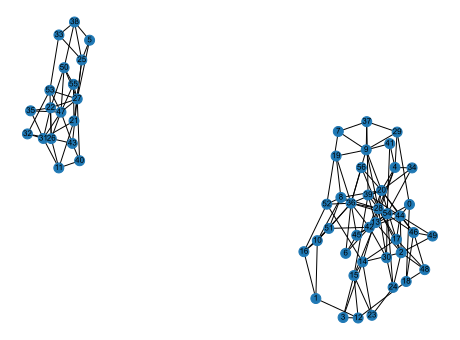

In [25]:
plot_graph(G, 8, 6, 100, 8, True, 'adjacency_matrix') 

In [26]:
get_graph_summary(G) 

Network Properties:
nodes, edges			57, 151
directed?			False
weighted?			False
isolated nodes			0
self-loops			0
density				0.094612
clustering coefficient		0.385943
min/max/avg degree		3, 14, 5.298246
degree assortativity		0.068953
number of connected components	2
size of largest component	39 (68.42 %)


Now, we look at the learned graph.

In [27]:
G_learned = get_graph_from_adjacency_matrix(supervisor.learned_adj_mx) 

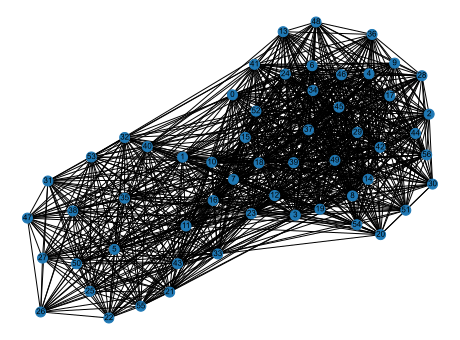

In [28]:
plot_graph(G_learned, 8, 6, 100, 8, True, 'learned_adjacency_matrix') 

In [29]:
get_graph_summary(G_learned) 

Network Properties:
nodes, edges			57, 925
directed?			False
weighted?			False
isolated nodes			0
self-loops			0
density				0.579574
clustering coefficient		0.745802
min/max/avg degree		20, 51, 32.456140
degree assortativity		0.053482
number of connected components	1
size of largest component	57 (100.00 %)


We can see that the learned graph is more densely connected than the kNN graph.

For later comparison, we now load the sales.

In [30]:
#original_sales = pd.read_hdf('./data/sales.h5') 
sales = pd.read_hdf('./data/sales.h5')
sales

territory,Blekinge,Blekinge ONCO,Dalarna,Dalarna ONCO,Gävleborg-Gävle,Gävleborg-Gävle ONCO,Halland-Halmstad,Halland-Halmstad ONCO,Halland-Varberg-Falkenberg,Jämtland,...,Västra Götaland-Göteborg ONCO,Västra Götaland-Lidköping,Västra Götaland-Skövde,Västra Götaland-SÄS ONCO,Västra Götaland-Uddevalla,Örebro-Örebro,Örebro-Örebro ONCO,Östergötland-Linköping,Östergötland-Linköping ONCO,Östergötland-Norrköping
0,61.0,288.0,30.0,326.0,10.0,198.0,30.0,96.0,30.0,0.0,...,1982.0,91.0,20.0,1319.0,30.0,91.0,294.0,0.0,548.0,0.0
1,122.0,526.0,51.0,325.0,0.0,466.0,51.0,96.0,30.0,0.0,...,2594.0,61.0,122.0,1137.0,51.0,30.0,576.0,0.0,630.0,0.0
2,30.0,123.0,51.0,537.0,30.0,133.0,51.0,288.0,30.0,0.0,...,2008.0,30.0,51.0,1452.0,61.0,152.0,585.0,0.0,619.0,0.0
3,122.0,336.0,51.0,154.0,30.0,304.0,20.0,154.0,30.0,0.0,...,2269.0,91.0,61.0,1352.0,30.0,152.0,560.0,0.0,490.0,0.0
4,103.0,127.0,42.0,75.0,101.0,372.0,106.0,270.0,52.0,42.0,...,1959.0,99.0,109.0,1315.0,30.0,135.0,607.0,30.0,633.0,0.0
5,108.0,199.0,0.0,127.0,87.0,246.0,64.0,87.0,21.0,50.0,...,1860.0,5.0,50.0,982.0,21.0,64.0,335.0,50.0,358.0,0.0
6,177.0,352.0,7.0,258.0,73.0,340.0,78.0,232.0,0.0,78.0,...,2593.0,21.0,28.0,1081.0,85.0,120.0,990.0,14.0,503.0,0.0
7,113.0,143.0,0.0,55.0,14.0,549.0,52.0,270.0,43.0,71.0,...,1789.0,57.0,0.0,1320.0,64.0,50.0,419.0,28.0,653.0,42.0
8,128.0,108.0,7.0,52.0,30.0,593.0,28.0,157.0,0.0,21.0,...,1885.0,43.0,50.0,1513.0,43.0,106.0,294.0,21.0,465.0,50.0
9,57.0,260.0,14.0,127.0,0.0,956.0,57.0,288.0,64.0,64.0,...,1912.0,43.0,21.0,1356.0,64.0,191.0,532.0,0.0,380.0,35.0


In [31]:
# Get dictionary of regions
regions_dict = dict()
for i, region in enumerate(sales.columns):
    regions_dict.update({i: region})
regions_dict

{0: 'Blekinge',
 1: 'Blekinge ONCO',
 2: 'Dalarna',
 3: 'Dalarna ONCO',
 4: 'Gävleborg-Gävle',
 5: 'Gävleborg-Gävle ONCO',
 6: 'Halland-Halmstad',
 7: 'Halland-Halmstad ONCO',
 8: 'Halland-Varberg-Falkenberg',
 9: 'Jämtland',
 10: 'Jämtland ONCO',
 11: 'Jönköping ONCO',
 12: 'Jönköping-Jönköping',
 13: 'Jönköping-Nässjö-Eksjö',
 14: 'Jönköping-Värnamo',
 15: 'Kalmar',
 16: 'Kalmar ONCO',
 17: 'Kronoberg-Ljungby',
 18: 'Kronoberg-Växjö',
 19: 'Kronoberg-Växjö ONCO',
 20: 'Norrbotten-Sunderbyn',
 21: 'Norrbotten-Sunderbyn ONCO',
 22: 'Skåne ONCO',
 23: 'Skåne-Helsingborg-Landskrona',
 24: 'Skåne-Kristianstad',
 25: 'Skåne-Lund',
 26: 'Stockholm',
 27: 'Stockholm ONCO',
 28: 'Stockholm-Gotland',
 29: 'Stockholm-Gotland ONCO',
 30: 'Sörmland-Eskilstuna',
 31: 'Sörmland-Eskilstuna ONCO',
 32: 'Uppsala',
 33: 'Uppsala ONCO',
 34: 'Värmland-Karlstad',
 35: 'Värmland-Karlstad ONCO',
 36: 'Västerbotten-Skellefteå',
 37: 'Västerbotten-Umeå',
 38: 'Västerbotten-Umeå ONCO',
 39: 'Västernorrland-Su

## Visualization of losses and metrics

We now visualize the losses and metrics.

### Losses over epochs

In [32]:
y_val_pred

tensor([[[ 137.1674,  263.0408,   40.5491,  164.4044,   52.2206,  562.4108,
            51.9778,  189.9186,   44.7432,   37.1281,  217.5390,  297.6085,
           123.1002,   59.4737,   48.7261,  181.2259,  276.4773,   37.2209,
           144.4338,   76.8975,   40.2341,  352.1403,  900.4917,  214.4340,
            70.1051,  568.8040,  649.2085, 2415.6758,   39.1766,   46.7092,
            40.5319,  484.0964,  306.8238,  368.3714,   44.7560,  435.3382,
            38.6206,   52.6499,  468.6078,  110.4501,  354.4652,   63.2205,
            36.1035,  462.5288,   33.3363,   41.7634,   36.0919, 1812.0160,
            42.5985,   38.5839,  974.2360,   66.7370,  112.2061,  331.4552,
            57.5836,  485.9945,   49.2035],
         [ 139.3362,  233.5844,   46.4454,  129.9558,   55.1207,  450.7400,
            62.8323,  194.1609,   41.9165,   42.5480,  159.0256,  294.7849,
           135.8222,   94.0342,   50.0757,  178.9929,  262.5057,   39.4668,
           154.7711,   79.6642,   43.5888,  

In [33]:
y_test_pred

tensor([[[  82.9451,  248.0365,   40.2868,  108.6853,   53.4438,  404.3243,
            49.5844,  189.1580,   46.4283,   53.5361,  181.5276,  304.1632,
           116.6298,   88.8255,   50.4041,  143.2425,  247.6203,   40.2378,
           129.3621,   67.0610,   38.0210,  314.4523, 1026.0024,  149.9372,
            62.4501,  512.7205,  678.1489, 2371.6887,   45.8789,   45.2347,
            42.4917,  533.7159,  326.8865,  346.4619,   38.5325,  421.0052,
            44.2701,   70.1405,  406.4893,   97.3600,  264.3158,   66.2860,
            36.4853,  359.1623,   37.6314,   39.7275,   42.1182, 1427.6393,
            39.2037,   44.2846, 1085.8942,   73.2926,  128.9299,  295.0692,
            50.6680,  544.7623,   44.4465],
         [  91.3697,  274.9943,   47.1179,  168.0594,   60.9523,  451.0860,
            62.3152,  215.8601,   43.0587,   57.8315,  205.4135,  322.4885,
           139.3890,   91.2727,   50.9583,  167.6319,  238.7294,   47.7395,
           156.9491,   72.1716,   40.0766,  

In [34]:
train_losses_list

[331.180430829525,
 309.6190495491028,
 287.13585460186005,
 261.57690513134,
 230.00709468126297,
 193.0860047340393,
 172.40306949615479,
 162.892744243145,
 161.51596307754517,
 160.76528441905975,
 155.54753363132477,
 144.37131929397583,
 132.7279920578003,
 121.54372453689575,
 117.65317022800446,
 123.57005667686462,
 128.19328904151917,
 128.7790334224701,
 125.24262380599976,
 119.43908762931824,
 114.16714310646057,
 114.41352820396423,
 115.62978529930115,
 114.8068540096283,
 115.42837619781494,
 113.4588713645935,
 111.03623700141907,
 109.12344574928284,
 107.87196958065033,
 108.76710295677185,
 108.88159012794495,
 108.75880348682404,
 107.63855999708176,
 106.42005670070648,
 104.47645771503448,
 105.7411562204361,
 106.75243377685547,
 106.09326457977295,
 103.89479327201843,
 104.41170179843903,
 102.09304583072662,
 104.950528383255,
 106.49197626113892,
 105.2334852218628,
 104.5939359664917,
 103.68655335903168,
 101.60483229160309,
 102.6175274848938,
 101.378031

In [35]:
val_losses_list

[272.29831898212433,
 250.33941066265106,
 225.2751412987709,
 197.23939448595047,
 164.90574902296066,
 127.32757222652435,
 111.49928379058838,
 111.12243038415909,
 109.52525919675827,
 111.8243003487587,
 103.17514103651047,
 100.73323059082031,
 99.99708366394043,
 106.11104303598404,
 113.58779776096344,
 116.6568591594696,
 117.34597837924957,
 112.49067890644073,
 105.5872585773468,
 98.32133054733276,
 91.27742898464203,
 88.62706112861633,
 86.79049944877625,
 86.7840451002121,
 86.52646148204803,
 87.84828495979309,
 88.91654121875763,
 91.32217478752136,
 92.92225557565689,
 92.5341607928276,
 92.06834900379181,
 87.2656347155571,
 85.43184584379196,
 84.88166952133179,
 81.98645436763763,
 79.17540287971497,
 79.62132465839386,
 82.23758804798126,
 84.78201580047607,
 81.23009836673737,
 82.01874709129333,
 85.8486624956131,
 89.23192501068115,
 88.74362921714783,
 89.39893281459808,
 86.53469979763031,
 84.04729729890823,
 82.4140732884407,
 84.63949126005173,
 81.6010205

In [36]:
test_losses_list

[283.76111805438995,
 262.4786013364792,
 239.77886444330215,
 213.92559748888016,
 182.44566601514816,
 153.16126668453217,
 141.72210025787354,
 140.53873592615128,
 136.43428629636765,
 129.8795753121376,
 121.5170676112175,
 111.93973541259766,
 106.9700984954834,
 110.04272943735123,
 116.60189688205719,
 122.38923525810242,
 122.68881285190582,
 118.92032825946808,
 112.05233120918274,
 104.32715177536011,
 98.92045724391937,
 98.1152126789093,
 98.86869311332703,
 100.79690062999725,
 100.43405425548553,
 100.19166874885559,
 97.8110648393631,
 97.85601115226746,
 99.85430818796158,
 99.45978182554245,
 97.7739382982254,
 96.02866572141647,
 96.02749556303024,
 98.6326994895935,
 96.26360738277435,
 96.74798130989075,
 96.33728992938995,
 96.94059097766876,
 96.5083646774292,
 93.88785898685455,
 92.76250624656677,
 94.18534767627716,
 96.26863765716553,
 97.28056311607361,
 94.96226441860199,
 93.30408608913422,
 93.01256066560745,
 95.71199351549149,
 95.83484190702438,
 93.43

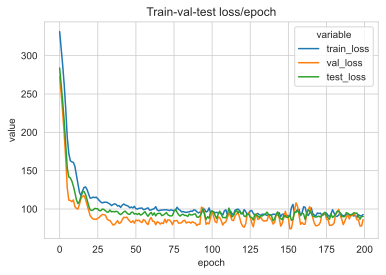

In [37]:
plot_loss_and_metrics(True, train_losses_list, val_losses_list, test_losses_list, \
                      columns = ['epoch', 'train_loss', 'val_loss', 'test_loss'], title = 'Train-val-test loss/epoch', \
                     save = True, filename = 'gts_losses')

### Metrics over epochs

#### MAE

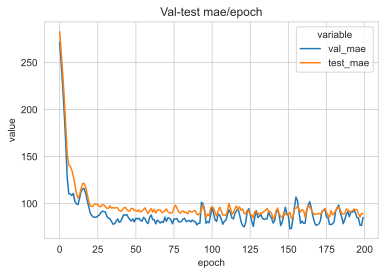

In [38]:
plot_loss_and_metrics(False, None, val_mae_list, test_mae_list, columns = ['epoch', 'val_mae', 'test_mae'], \
                      title = 'Val-test mae/epoch', save = True, filename = 'gts_mae')

Comment: The losses and MAE values are so similar because they only differ for the regularized loss $\lambda\ell_{\textit{reg}}$, where $\lambda=1$.

#### MAPE

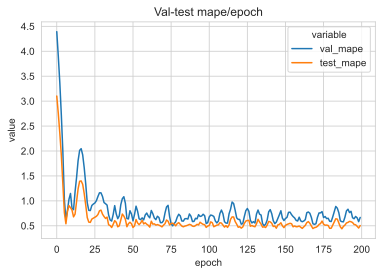

In [39]:
plot_loss_and_metrics(False, None, val_mape_list, test_mape_list, columns = ['epoch', 'val_mape', 'test_mape'], \
                      title = 'Val-test mape/epoch', save = True, filename = 'gts_mape')

#### RMSE

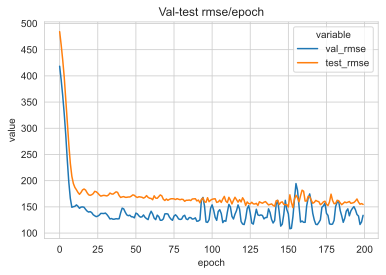

In [40]:
plot_loss_and_metrics(False, None, val_rmse_list, test_rmse_list, columns = ['epoch', 'val_rmse', 'test_rmse'], \
                      title = 'Val-test rmse/epoch', save = True, filename = 'gts_rmse')

## Forecasts

Let us take a look at the forecasts.

In [41]:
# Create forecasts folder
route0 = "./forecasts"

if not os.path.exists(route0):
    os.mkdir(route0)

In [42]:
date_dict = dict({0: '09-2019', 1: '10-2019', 2: '11-2019', 3: '12-2019', 4: '01-2020', 5: '02-2020', 6: '03-2020', 
                  7: '04-2020', 8: '05-2020', 9: '06-2020', 10: '07-2020', 11: '08-2020', 12: '09-2020', 13: '10-2020',
                 14: '11-2020', 15: '12-2020', 16: '01-2021', 17: '02-2021', 18: '03-2021', 19: '04-2021', 20: '05-2021', 
                 21: '06-2021', 22: '07-2021', 23: '08-2021'})

In [43]:
original_sales = pd.read_hdf('./data/sales.h5') 

original_sales['time'] = original_sales.index.map(date_dict)
original_sales['type'] = 'original'

In [44]:
original_sales

territory,Blekinge,Blekinge ONCO,Dalarna,Dalarna ONCO,Gävleborg-Gävle,Gävleborg-Gävle ONCO,Halland-Halmstad,Halland-Halmstad ONCO,Halland-Varberg-Falkenberg,Jämtland,...,Västra Götaland-Skövde,Västra Götaland-SÄS ONCO,Västra Götaland-Uddevalla,Örebro-Örebro,Örebro-Örebro ONCO,Östergötland-Linköping,Östergötland-Linköping ONCO,Östergötland-Norrköping,time,type
0,61.0,288.0,30.0,326.0,10.0,198.0,30.0,96.0,30.0,0.0,...,20.0,1319.0,30.0,91.0,294.0,0.0,548.0,0.0,09-2019,original
1,122.0,526.0,51.0,325.0,0.0,466.0,51.0,96.0,30.0,0.0,...,122.0,1137.0,51.0,30.0,576.0,0.0,630.0,0.0,10-2019,original
2,30.0,123.0,51.0,537.0,30.0,133.0,51.0,288.0,30.0,0.0,...,51.0,1452.0,61.0,152.0,585.0,0.0,619.0,0.0,11-2019,original
3,122.0,336.0,51.0,154.0,30.0,304.0,20.0,154.0,30.0,0.0,...,61.0,1352.0,30.0,152.0,560.0,0.0,490.0,0.0,12-2019,original
4,103.0,127.0,42.0,75.0,101.0,372.0,106.0,270.0,52.0,42.0,...,109.0,1315.0,30.0,135.0,607.0,30.0,633.0,0.0,01-2020,original
5,108.0,199.0,0.0,127.0,87.0,246.0,64.0,87.0,21.0,50.0,...,50.0,982.0,21.0,64.0,335.0,50.0,358.0,0.0,02-2020,original
6,177.0,352.0,7.0,258.0,73.0,340.0,78.0,232.0,0.0,78.0,...,28.0,1081.0,85.0,120.0,990.0,14.0,503.0,0.0,03-2020,original
7,113.0,143.0,0.0,55.0,14.0,549.0,52.0,270.0,43.0,71.0,...,0.0,1320.0,64.0,50.0,419.0,28.0,653.0,42.0,04-2020,original
8,128.0,108.0,7.0,52.0,30.0,593.0,28.0,157.0,0.0,21.0,...,50.0,1513.0,43.0,106.0,294.0,21.0,465.0,50.0,05-2020,original
9,57.0,260.0,14.0,127.0,0.0,956.0,57.0,288.0,64.0,64.0,...,21.0,1356.0,64.0,191.0,532.0,0.0,380.0,35.0,06-2020,original


In [45]:
print("saving file corresponding to original_sales.pkl")
original_sales.to_pickle(f"{route0}/original_sales.pkl")

saving file corresponding to original_sales.pkl


In [46]:
original_sales = pd.read_pickle(f"{route0}/original_sales.pkl") 
original_sales

territory,Blekinge,Blekinge ONCO,Dalarna,Dalarna ONCO,Gävleborg-Gävle,Gävleborg-Gävle ONCO,Halland-Halmstad,Halland-Halmstad ONCO,Halland-Varberg-Falkenberg,Jämtland,...,Västra Götaland-Skövde,Västra Götaland-SÄS ONCO,Västra Götaland-Uddevalla,Örebro-Örebro,Örebro-Örebro ONCO,Östergötland-Linköping,Östergötland-Linköping ONCO,Östergötland-Norrköping,time,type
0,61.0,288.0,30.0,326.0,10.0,198.0,30.0,96.0,30.0,0.0,...,20.0,1319.0,30.0,91.0,294.0,0.0,548.0,0.0,09-2019,original
1,122.0,526.0,51.0,325.0,0.0,466.0,51.0,96.0,30.0,0.0,...,122.0,1137.0,51.0,30.0,576.0,0.0,630.0,0.0,10-2019,original
2,30.0,123.0,51.0,537.0,30.0,133.0,51.0,288.0,30.0,0.0,...,51.0,1452.0,61.0,152.0,585.0,0.0,619.0,0.0,11-2019,original
3,122.0,336.0,51.0,154.0,30.0,304.0,20.0,154.0,30.0,0.0,...,61.0,1352.0,30.0,152.0,560.0,0.0,490.0,0.0,12-2019,original
4,103.0,127.0,42.0,75.0,101.0,372.0,106.0,270.0,52.0,42.0,...,109.0,1315.0,30.0,135.0,607.0,30.0,633.0,0.0,01-2020,original
5,108.0,199.0,0.0,127.0,87.0,246.0,64.0,87.0,21.0,50.0,...,50.0,982.0,21.0,64.0,335.0,50.0,358.0,0.0,02-2020,original
6,177.0,352.0,7.0,258.0,73.0,340.0,78.0,232.0,0.0,78.0,...,28.0,1081.0,85.0,120.0,990.0,14.0,503.0,0.0,03-2020,original
7,113.0,143.0,0.0,55.0,14.0,549.0,52.0,270.0,43.0,71.0,...,0.0,1320.0,64.0,50.0,419.0,28.0,653.0,42.0,04-2020,original
8,128.0,108.0,7.0,52.0,30.0,593.0,28.0,157.0,0.0,21.0,...,50.0,1513.0,43.0,106.0,294.0,21.0,465.0,50.0,05-2020,original
9,57.0,260.0,14.0,127.0,0.0,956.0,57.0,288.0,64.0,64.0,...,21.0,1356.0,64.0,191.0,532.0,0.0,380.0,35.0,06-2020,original


### Save forecasts

Before saving the forecasts, we extend the two data frames `y_predict_val_st` and `y_predict_test_st` by the columns `time` and `type`, indicating the respective month for which the forecasts were generated and the method with which they were generated (in this case: 'static').

In [47]:
# Create forecasts folder
route0 = "./forecasts"

if not os.path.exists(route0):
    os.mkdir(route0)

In [48]:
date_dict = dict({0: '09-2019', 1: '10-2019', 2: '11-2019', 3: '12-2019', 4: '01-2020', 5: '02-2020', 6: '03-2020', 
                  7: '04-2020', 8: '05-2020', 9: '06-2020', 10: '07-2020', 11: '08-2020', 12: '09-2020', 13: '10-2020',
                 14: '11-2020', 15: '12-2020', 16: '01-2021', 17: '02-2021', 18: '03-2021', 19: '04-2021', 20: '05-2021', 
                 21: '06-2021', 22: '07-2021', 23: '08-2021'})

In [49]:
y_predict_val_gts = pd.read_pickle(f"{route0}/y_predict_val_st.pkl") 
y_predict_val_gts = y_predict_val_gts.drop(columns=['time', 'type'])
y_predict_test_gts = pd.read_pickle(f"{route0}/y_predict_test_st.pkl") 
y_predict_test_gts = y_predict_test_gts.drop(columns=['time', 'type'])
val_indices = y_predict_val_gts.index
test_indices = y_predict_test_gts.index
val_columns = y_predict_val_gts.columns
test_columns = y_predict_test_gts.columns

#### Validation set

In [50]:
y_predict_val_gts = pd.DataFrame(np.array(y_val_pred[0]), index=val_indices, columns=val_columns)

y_predict_val_gts['time'] = y_predict_val_gts.index.map(date_dict)
y_predict_val_gts['type'] = 'gts'

In [51]:
print("saving file corresponding to y_predict_val_gts.pkl")
y_predict_val_gts.to_pickle(f"{route0}/y_predict_val_gts.pkl")

saving file corresponding to y_predict_val_gts.pkl


In [52]:
y_predict_val_gts = pd.read_pickle(f"{route0}/y_predict_val_gts.pkl") 
y_predict_val_gts

territory,Blekinge,Blekinge ONCO,Dalarna,Dalarna ONCO,Gävleborg-Gävle,Gävleborg-Gävle ONCO,Halland-Halmstad,Halland-Halmstad ONCO,Halland-Varberg-Falkenberg,Jämtland,...,Västra Götaland-Skövde,Västra Götaland-SÄS ONCO,Västra Götaland-Uddevalla,Örebro-Örebro,Örebro-Örebro ONCO,Östergötland-Linköping,Östergötland-Linköping ONCO,Östergötland-Norrköping,time,type
15,137.167450,263.040771,40.549103,164.404373,52.220642,562.410767,51.977798,189.918564,44.743195,37.128052,...,38.583923,974.235962,66.737000,112.206146,331.455231,57.583557,485.994476,49.203522,12-2020,gts
16,139.336182,233.584381,46.445404,129.955765,55.120651,450.739990,62.832336,194.160858,41.916473,42.547974,...,41.625610,1197.530762,83.099976,99.537643,296.330872,57.825851,532.002075,52.286697,01-2021,gts
17,139.724716,231.391876,45.488525,118.250610,58.055023,456.013611,62.185013,154.024643,51.668274,40.576294,...,43.793610,1171.855347,83.236115,111.628082,359.842163,59.946487,497.144592,50.364456,02-2021,gts


#### Test set

In [53]:
y_predict_test_gts = pd.DataFrame(np.array(y_test_pred[0]), index=test_indices, columns=test_columns)

y_predict_test_gts['time'] = y_predict_test_gts.index.map(date_dict)
y_predict_test_gts['type'] = 'gts'

In [54]:
print("saving file corresponding to y_predict_test_gts.pkl")
y_predict_test_gts.to_pickle(f"{route0}/y_predict_test_gts.pkl")

saving file corresponding to y_predict_test_gts.pkl


In [55]:
y_predict_test_gts = pd.read_pickle(f"{route0}/y_predict_test_gts.pkl") 
y_predict_test_gts

territory,Blekinge,Blekinge ONCO,Dalarna,Dalarna ONCO,Gävleborg-Gävle,Gävleborg-Gävle ONCO,Halland-Halmstad,Halland-Halmstad ONCO,Halland-Varberg-Falkenberg,Jämtland,...,Västra Götaland-Skövde,Västra Götaland-SÄS ONCO,Västra Götaland-Uddevalla,Örebro-Örebro,Örebro-Örebro ONCO,Östergötland-Linköping,Östergötland-Linköping ONCO,Östergötland-Norrköping,time,type
18,82.945129,248.036514,40.286835,108.685303,53.443756,404.324341,49.584412,189.158020,46.428345,53.536102,...,44.284637,1085.894165,73.292557,128.929916,295.069214,50.667969,544.762329,44.446472,03-2021,gts
19,91.369720,274.994263,47.117889,168.059418,60.952271,451.085999,62.315231,215.860138,43.058716,57.831451,...,47.983032,1234.771973,86.491592,146.650681,339.683838,45.986603,411.910461,41.887268,04-2021,gts
20,99.238113,276.829865,47.243927,147.228836,63.377640,468.236969,59.827026,225.912872,48.101746,57.429504,...,52.362289,983.832153,103.607086,152.955124,322.343048,48.487122,555.360107,45.261536,05-2021,gts
21,90.557739,260.635406,41.865692,137.575592,64.149429,392.581635,58.013718,178.063232,41.201721,56.431473,...,53.779373,1175.474243,86.982330,136.724350,323.229675,43.791168,516.761353,41.251404,06-2021,gts
22,114.856400,290.135651,50.666656,122.583099,66.863678,383.213409,68.770813,227.015015,41.437469,62.355270,...,50.400925,1135.473999,100.477615,138.543823,399.050934,54.006210,542.966125,44.735626,07-2021,gts
23,87.005630,330.023773,44.792572,144.956650,59.000565,451.657227,44.071167,200.589081,37.297302,60.232819,...,41.341614,1065.390991,84.258209,127.468750,325.810181,51.793457,529.637451,39.455139,08-2021,gts
